In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)

DATE_COL = "Date"  # change if your date col has a different name

# ===========================
# 1. Utils
# ===========================

def load_master_csv(path, date_col=DATE_COL):
    """Load data, parse date, sort by date."""
    df = pd.read_csv(path)
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col)
    return df

def add_regime_flags(df, date_col=DATE_COL):
    """
    Add 'regime' column: GFC, COVID, Other.
    GFC  ~ 2007-07 to 2009-06
    COVID ~ 2020-02 to 2021-12
    """
    df = df.copy()
    d = df[date_col]

    gfc_start   = pd.Timestamp("2007-07-01")
    gfc_end     = pd.Timestamp("2009-06-30")
    covid_start = pd.Timestamp("2020-02-01")
    covid_end   = pd.Timestamp("2021-12-31")

    conditions = [
        (d >= gfc_start) & (d <= gfc_end),
        (d >= covid_start) & (d <= covid_end)
    ]
    choices = ["GFC", "COVID"]

    df["regime"] = np.select(conditions, choices, default="Other")
    return df

# ===========================
# 2. Core EDA pieces
# ===========================

def basic_summary(df, target):
    print("\n==== BASIC INFO ====")
    print("Shape:", df.shape)
    print("\nColumns:\n", df.columns.tolist())
    print("\nTarget summary:")
    print(df[target].describe())
    print("\nMissing values (top 20):")
    print(df.isna().sum().sort_values(ascending=False).head(20))


def plot_target_time_series(df, target, label="", date_col=DATE_COL):
    print("\n==== TARGET TIME SERIES ====")
    plt.figure()
    plt.plot(df[date_col], df[target])
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.title(f"{label} – {target} over time")
    plt.tight_layout()
    plt.show()


def plot_distributions(df, target, label="", num_top_features=4):
    print("\n==== DISTRIBUTIONS ====")
    num_df = df.select_dtypes(include=[np.number])
    num_cols = num_df.columns.tolist()

    # Target distribution
    plt.figure()
    sns.histplot(df[target].dropna(), kde=True)
    plt.title(f"{label} – Distribution of {target}")
    plt.tight_layout()
    plt.show()

    # Pick top numeric predictors by |corr| with target
    num_cols = [c for c in num_cols if c != target]
    if len(num_cols) == 0:
        return

    corr_with_target = num_df[num_cols].corrwith(num_df[target]).abs().sort_values(ascending=False)
    top_feats = corr_with_target.index[:num_top_features]

    for col in top_feats:
        plt.figure()
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f"{label} – Distribution of {col}")
        plt.tight_layout()
        plt.show()


def corr_and_scatter(df, target, label="", num_top_features=10):
    print("\n==== CORRELATIONS WITH TARGET ====")
    num_df = df.select_dtypes(include=[np.number]).dropna()
    num_cols = num_df.columns.tolist()
    if target not in num_cols:
        print("Target not numeric or missing.")
        return

    # Correlation with target
    corr_target = num_df.corr()[target].sort_values(ascending=False)
    print(corr_target)

    # Heatmap for top features (+ target)
    top_feats = corr_target.drop(labels=[target]).abs().sort_values(ascending=False).head(num_top_features).index
    cols_for_heatmap = [target] + list(top_feats)
    plt.figure(figsize=(8, 6))
    sns.heatmap(num_df[cols_for_heatmap].corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"{label} – Correlation heatmap (target + top features)")
    plt.tight_layout()
    plt.show()

    # Scatter plots vs target
    print("\n==== SCATTER PLOTS VS TARGET ====")
    for col in top_feats:
        plt.figure()
        sns.scatterplot(x=df[col], y=df[target])
        plt.xlabel(col)
        plt.ylabel(target)
        plt.title(f"{label} – {target} vs {col}")
        plt.tight_layout()
        plt.show()


def regime_stability(df, target, label="", date_col=DATE_COL):
    print("\n==== REGIME STABILITY (GFC, COVID) ====")
    df = add_regime_flags(df, date_col=date_col)

    # Basic regime stats for target
    regime_stats = df.groupby("regime")[target].agg(["mean", "std", "count"])
    print(regime_stats)

    # Boxplot
    plt.figure()
    sns.boxplot(x="regime", y=target, data=df)
    plt.title(f"{label} – {target} by regime")
    plt.tight_layout()
    plt.show()

    # Time series with colored regimes for visual sanity check
    plt.figure()
    for reg, sub in df.groupby("regime"):
        plt.plot(sub[date_col], sub[target], label=reg)
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.title(f"{label} – {target} over time by regime")
    plt.legend()
    plt.tight_layout()
    plt.show()


def autocorr_diagnostics(df, target, label=""):
    print("\n==== AUTOCORRELATION DIAGNOSTICS ====")
    series = df[target].dropna()

    # ACF plot
    plt.figure()
    plot_acf(series, lags=24)
    plt.title(f"{label} – ACF of {target}")
    plt.tight_layout()
    plt.show()

    # Ljung-Box test at a few lags
    lb = acorr_ljungbox(series, lags=[6, 12, 24], return_df=True)
    print("Ljung-Box test (H0: no autocorrelation):")
    print(lb)


# ===========================
# 3. Wrapper for one dataset
# ===========================

def eda_one_dataset(path, target, label=""):
    print(f"\n\n==============================")
    print(f"EDA for: {label}")
    print(f"File: {path}")
    print("==============================")

    df = load_master_csv(path)

    basic_summary(df, target)
    plot_target_time_series(df, target, label=label)
    plot_distributions(df, target, label=label)
    corr_and_scatter(df, target, label=label)
    regime_stability(df, target, label=label)
    autocorr_diagnostics(df, target, label=label)

    return df  # return in case you want to reuse



EDA for: IG (with liquidity)
File: data/master/master_IG_w_lqd.csv

==== BASIC INFO ====
Shape: (108, 31)

Columns:
 ['Date', 'mkt_par_lb', 'mkt_n_trades', 'mkt_px_std_daily', 'dIG_spread', 'dIG_spread_lag1', 'VIXCLS_level', 'cpi_mom', 'cpi_mom_lag1', 'core_cpi_mom', 'core_cpi_mom_lag1', 'pce_mom', 'pce_mom_lag1', 'indpro_mom', 'indpro_mom_lag1', 'ccsa_growth', 'ccsa_growth_lag1', 'UNRATE_lag1', 'dT5YIFR', 'dT5YIFR_lag1', 'dT5YIE', 'dT5YIE_lag1', 'dT10YIE', 'dT10YIE_lag1', 'ln_mkt_par_lb', 'ln_mkt_par_lb_lag1', 'ln_mkt_n_trades', 'ln_mkt_n_trades_lag1', 'mkt_px_std_daily_lag1', 'dmkt_px_std_daily', 'dmkt_px_std_daily_lag1']

Target summary:
count    108.000000
mean       0.473909
std       29.707614
min     -117.157143
25%       -8.429301
50%       -0.142434
75%        6.084087
max      157.907585
Name: dIG_spread, dtype: float64

Missing values (top 20):
Date                     0
ccsa_growth_lag1         0
dmkt_px_std_daily        0
mkt_px_std_daily_lag1    0
ln_mkt_n_trades_lag1  

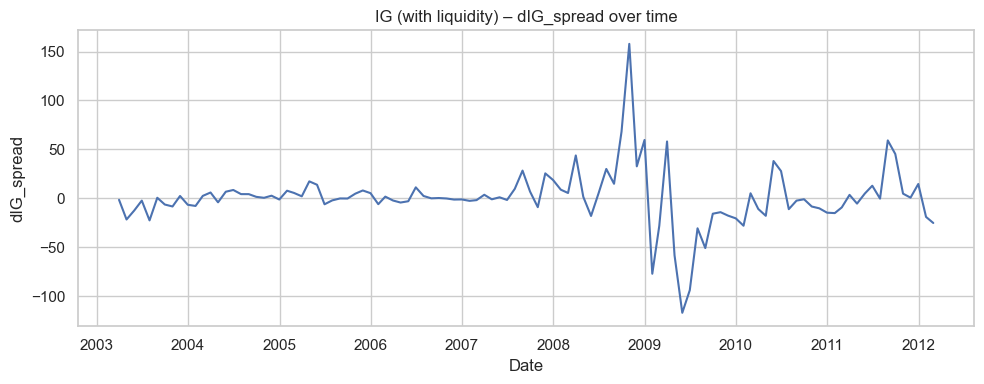


==== DISTRIBUTIONS ====


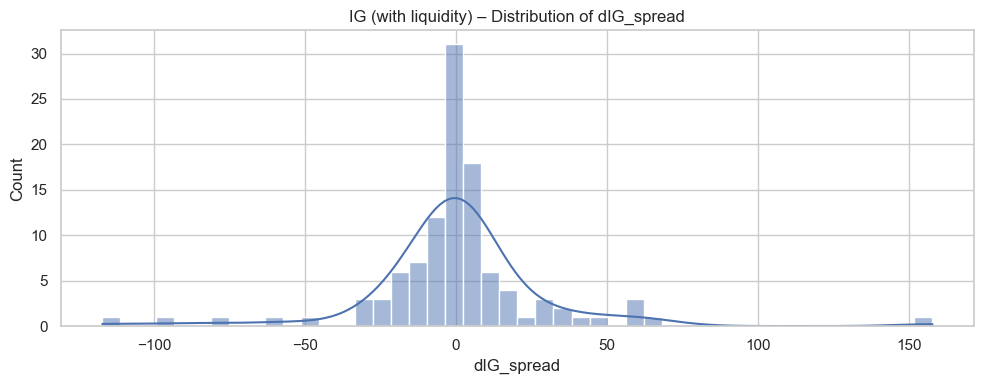

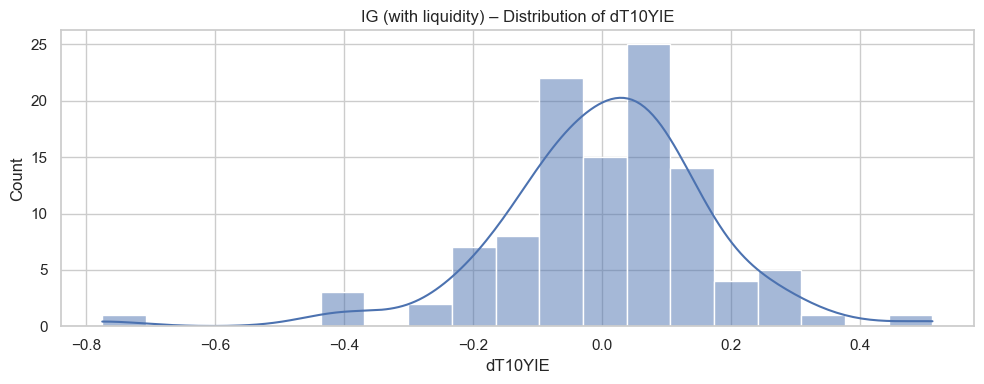

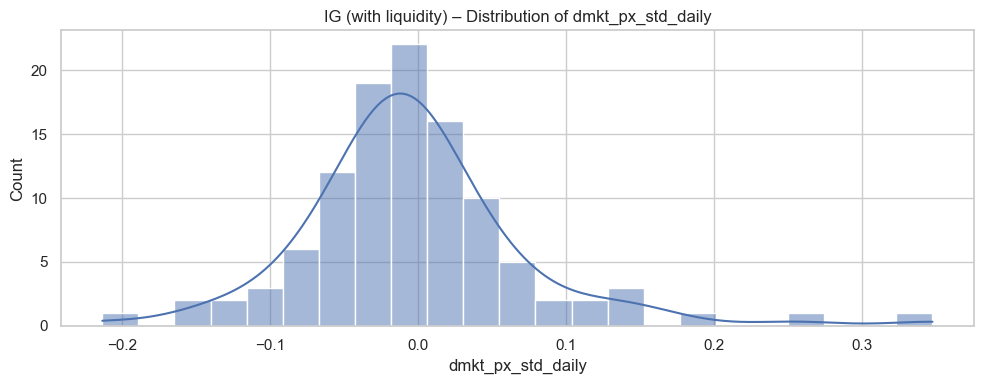

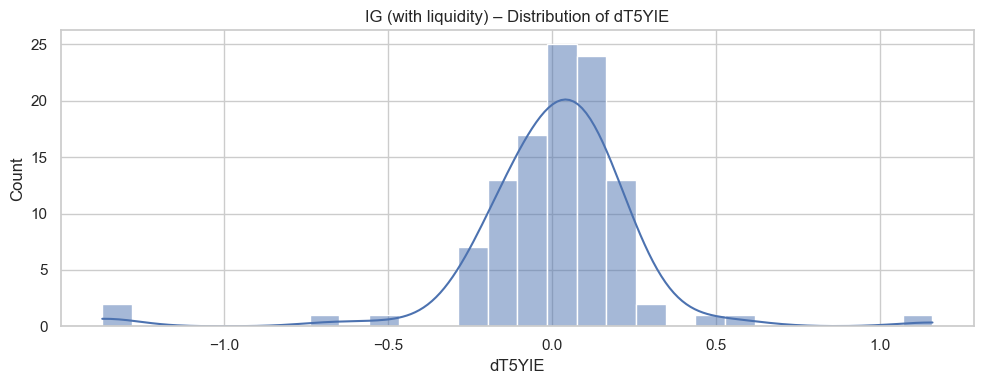

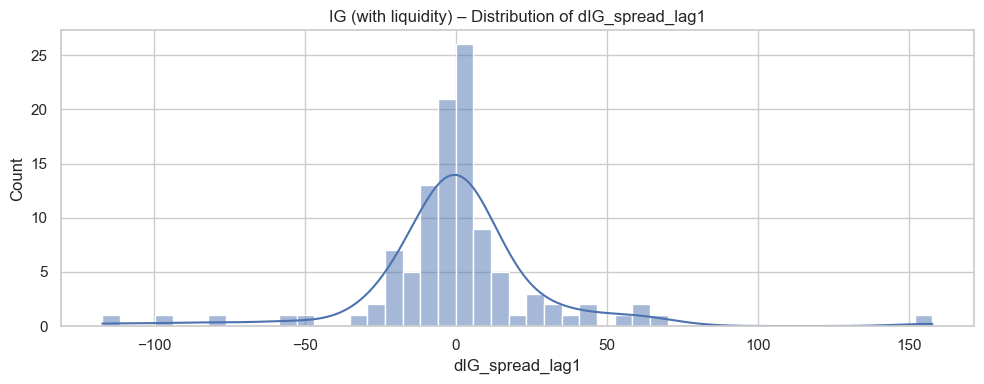


==== CORRELATIONS WITH TARGET ====
dIG_spread                1.000000
dmkt_px_std_daily         0.548706
dIG_spread_lag1           0.447313
dmkt_px_std_daily_lag1    0.286650
VIXCLS_level              0.267073
ccsa_growth               0.205293
dT5YIFR_lag1              0.170382
core_cpi_mom_lag1         0.151885
mkt_px_std_daily          0.146466
ccsa_growth_lag1          0.074674
core_cpi_mom              0.055421
cpi_mom_lag1             -0.014634
pce_mom_lag1             -0.026160
indpro_mom               -0.051593
ln_mkt_n_trades          -0.087977
mkt_px_std_daily_lag1    -0.136832
indpro_mom_lag1          -0.142221
ln_mkt_par_lb            -0.143735
ln_mkt_n_trades_lag1     -0.159428
mkt_n_trades             -0.161509
mkt_par_lb               -0.187590
ln_mkt_par_lb_lag1       -0.220027
UNRATE_lag1              -0.230313
dT10YIE_lag1             -0.253577
cpi_mom                  -0.306097
pce_mom                  -0.329404
dT5YIFR                  -0.397555
dT5YIE_lag1        

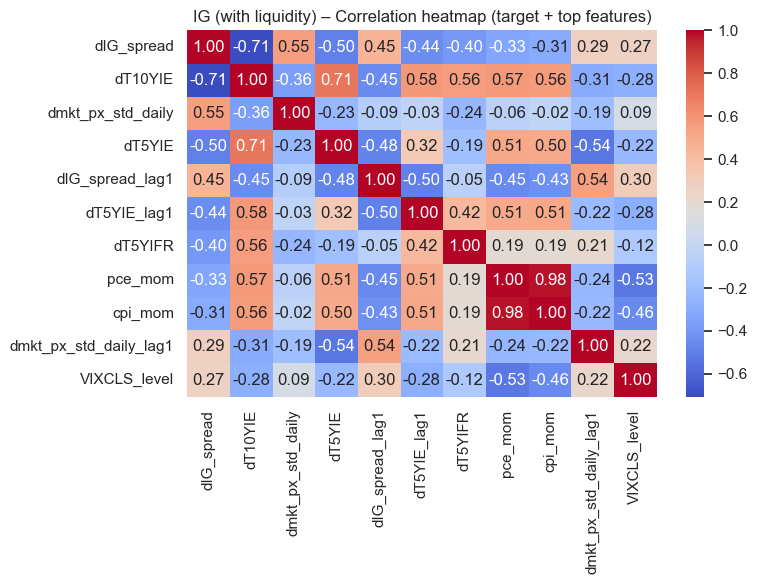


==== SCATTER PLOTS VS TARGET ====


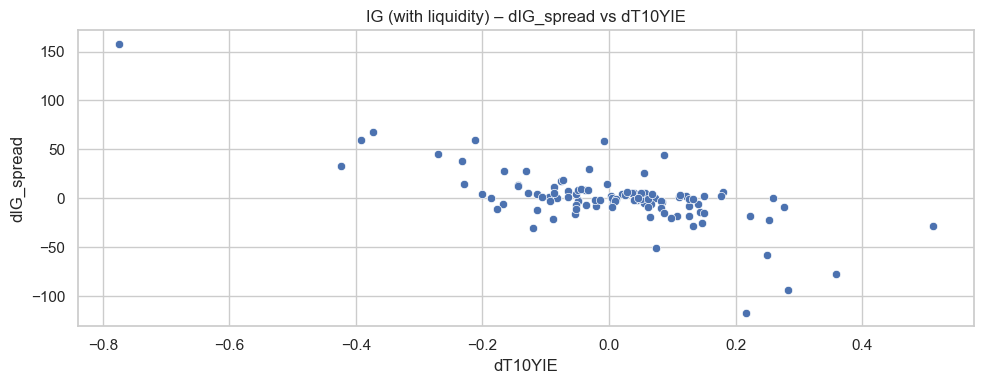

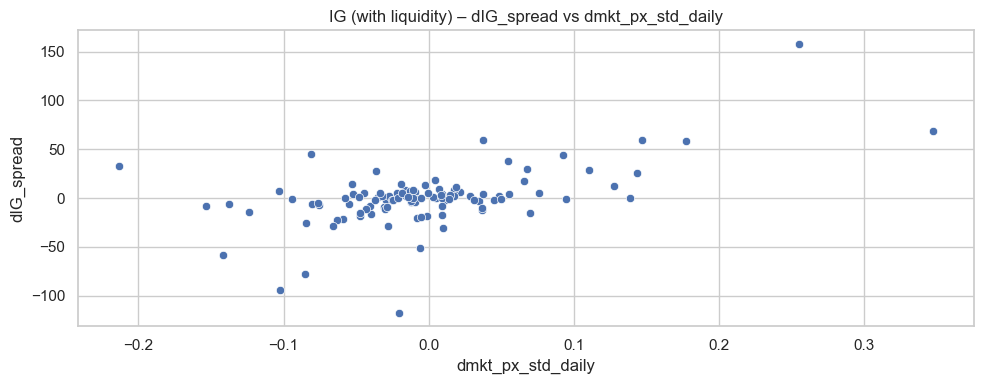

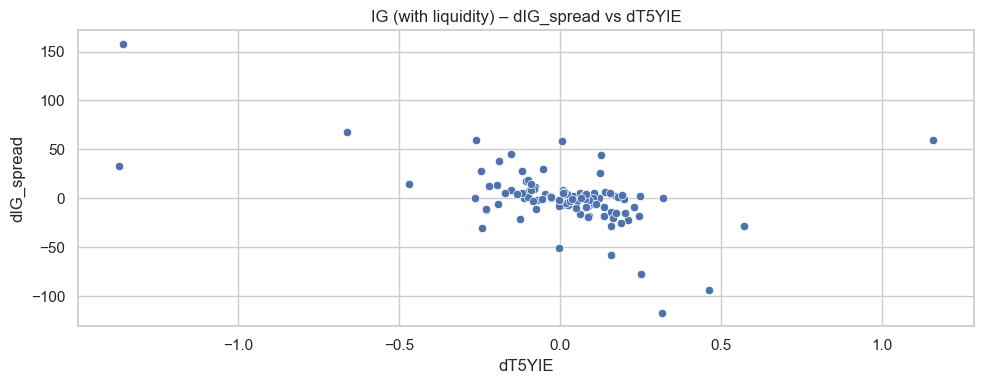

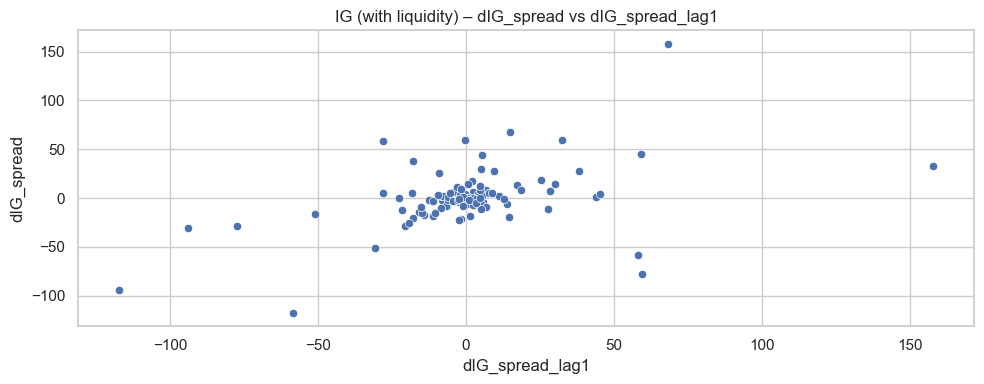

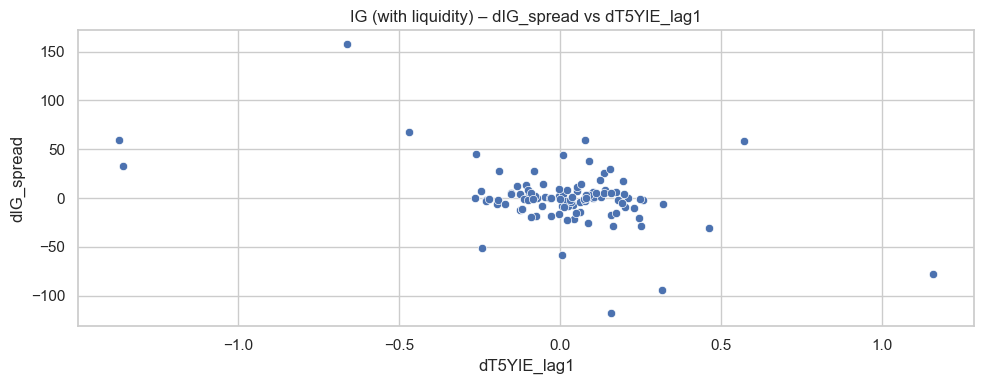

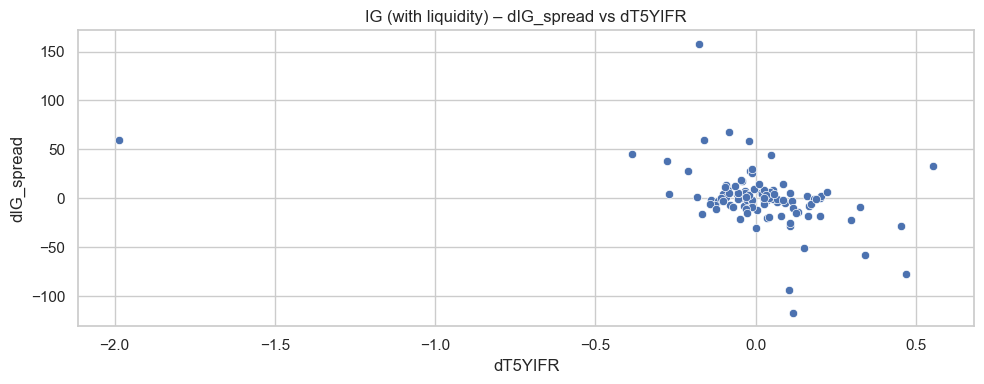

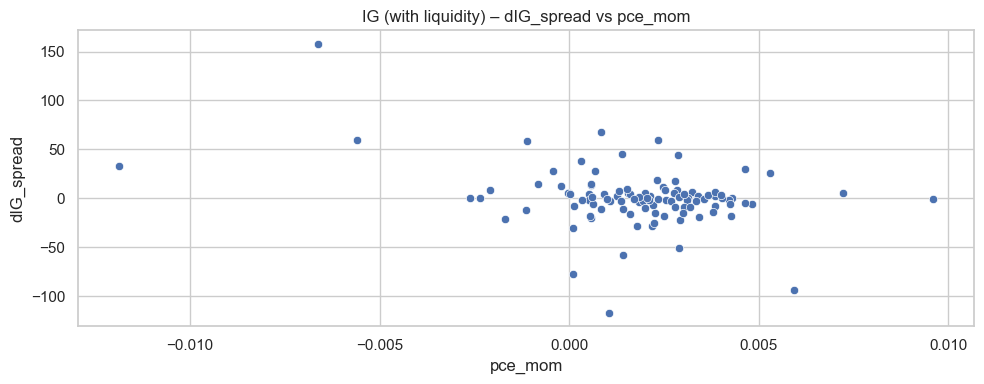

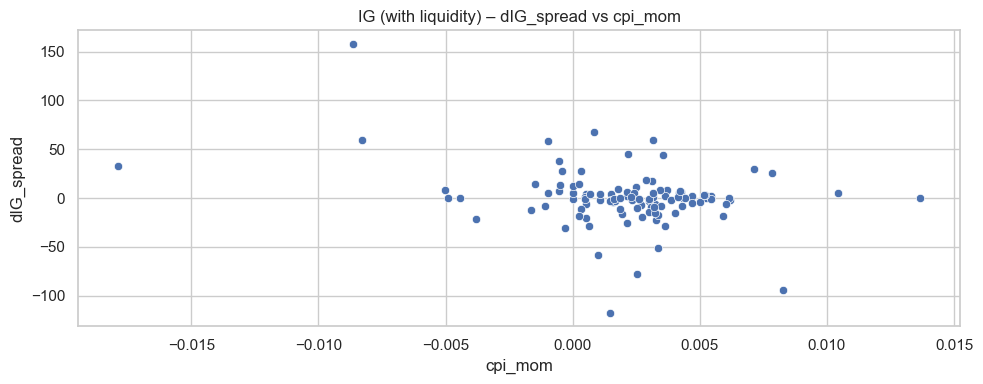

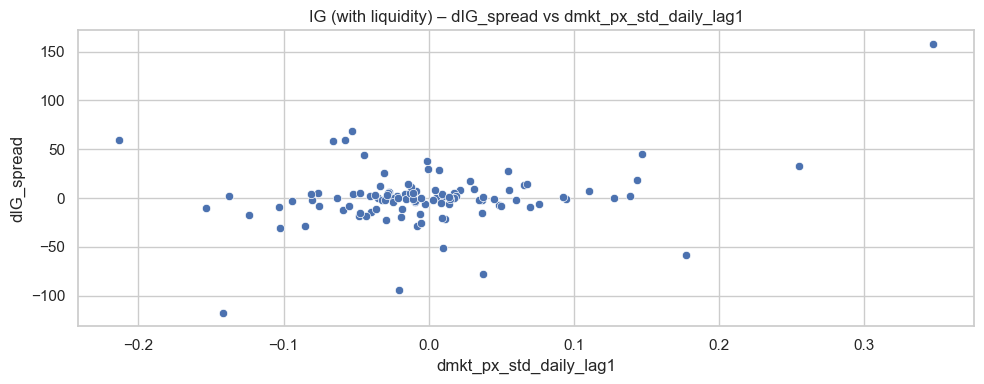

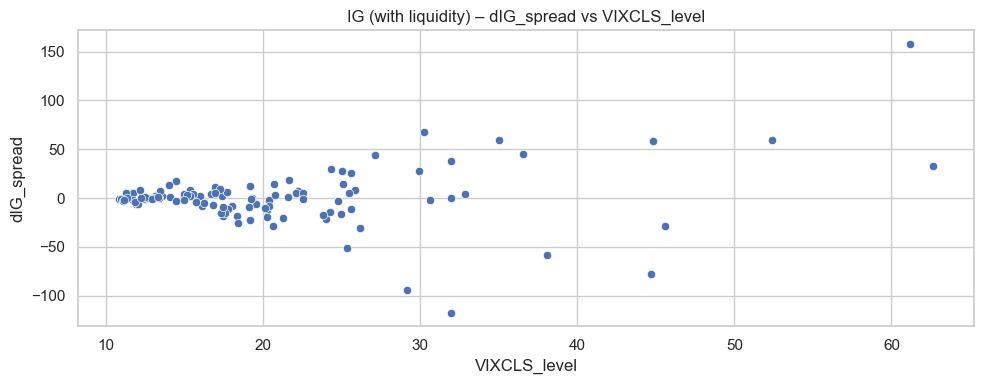


==== REGIME STABILITY (GFC, COVID) ====
            mean        std  count
regime                            
GFC     7.182359  56.944648     24
Other  -1.442791  14.913976     84


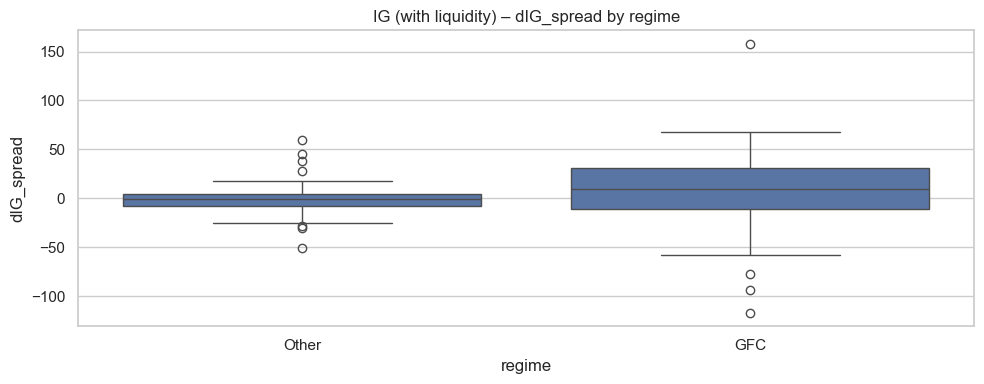

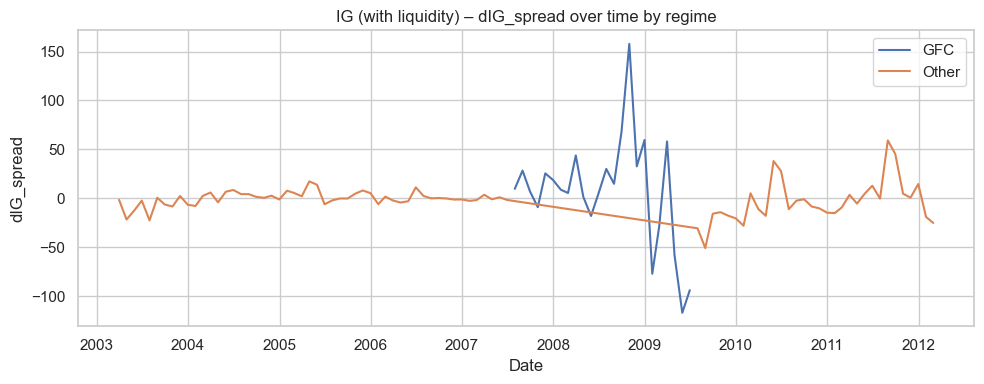


==== AUTOCORRELATION DIAGNOSTICS ====


<Figure size 1000x400 with 0 Axes>

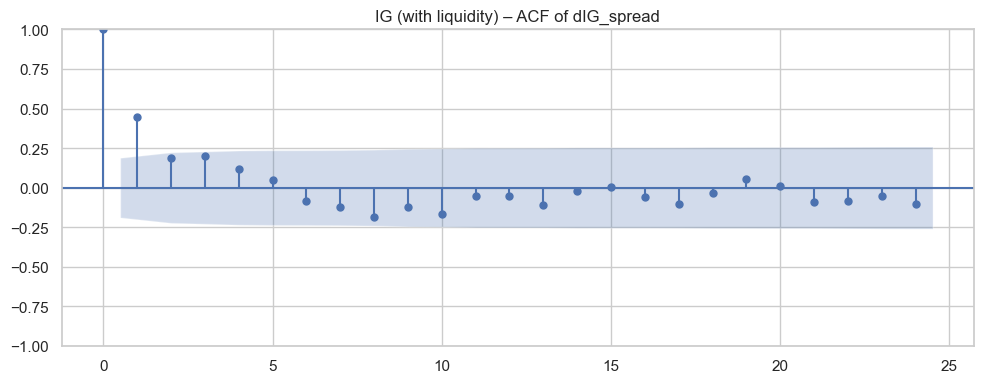

Ljung-Box test (H0: no autocorrelation):
      lb_stat  lb_pvalue
6   33.070592   0.000010
12  44.863498   0.000011
24  53.111776   0.000559


In [37]:
# ===========================
# 4. Example usage for your 4 files
# ===========================
# Adjust paths if needed (e.g. "./data/master_IG_w_lqd.csv")

# IG with liquidity
df_ig_w = eda_one_dataset("data/master/master_IG_w_lqd.csv", target="dIG_spread",
                          label="IG (with liquidity)")



EDA for: HY (with liquidity)
File: data/master/master_HY_w_lqd.csv

==== BASIC INFO ====
Shape: (108, 31)

Columns:
 ['Date', 'mkt_par_lb', 'mkt_n_trades', 'mkt_px_std_daily', 'dHY_spread', 'dHY_spread_lag1', 'VIXCLS_level', 'cpi_mom', 'cpi_mom_lag1', 'core_cpi_mom', 'core_cpi_mom_lag1', 'pce_mom', 'pce_mom_lag1', 'indpro_mom', 'indpro_mom_lag1', 'ccsa_growth', 'ccsa_growth_lag1', 'UNRATE_lag1', 'dT5YIFR', 'dT5YIFR_lag1', 'dT5YIE', 'dT5YIE_lag1', 'dT10YIE', 'dT10YIE_lag1', 'ln_mkt_par_lb', 'ln_mkt_par_lb_lag1', 'ln_mkt_n_trades', 'ln_mkt_n_trades_lag1', 'mkt_px_std_daily_lag1', 'dmkt_px_std_daily', 'dmkt_px_std_daily_lag1']

Target summary:
count    108.000000
mean      -1.963193
std       98.571158
min     -354.059091
25%      -35.441558
50%      -12.989436
75%       22.365963
max      576.424620
Name: dHY_spread, dtype: float64

Missing values (top 20):
Date                     0
ccsa_growth_lag1         0
dmkt_px_std_daily        0
mkt_px_std_daily_lag1    0
ln_mkt_n_trades_lag1  

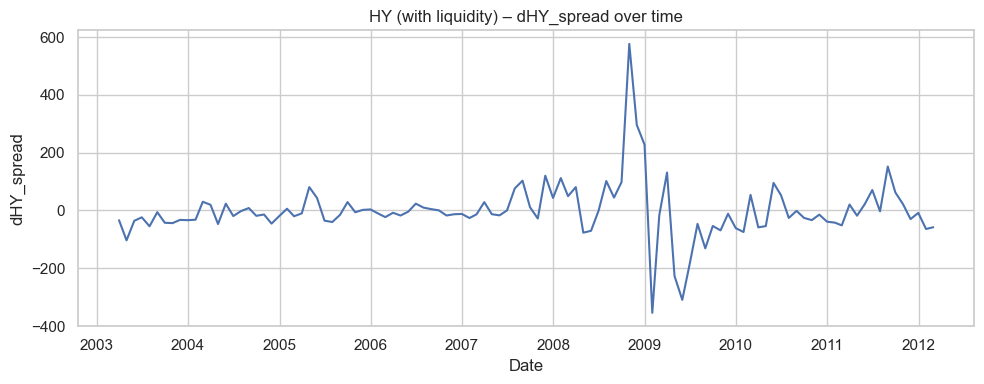


==== DISTRIBUTIONS ====


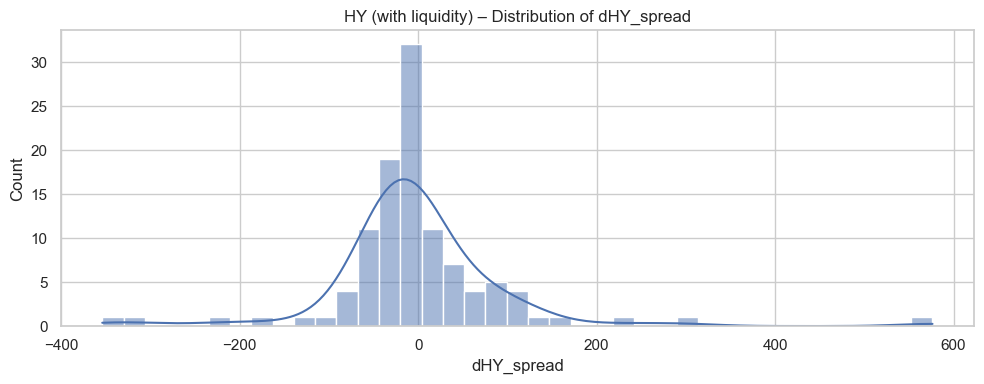

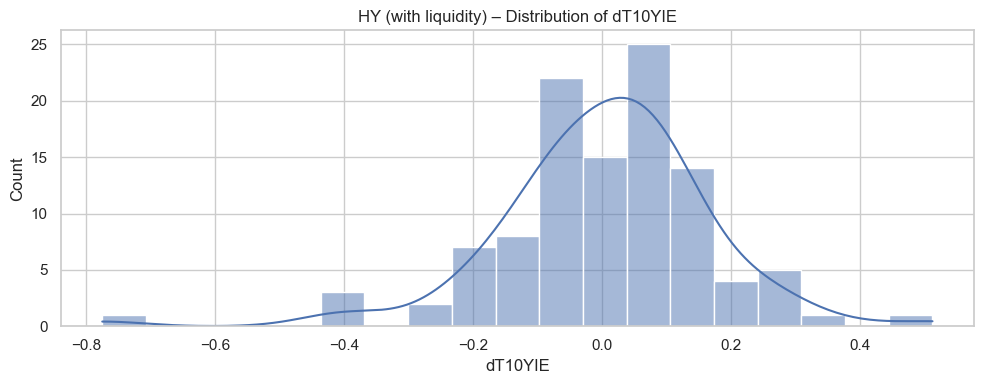

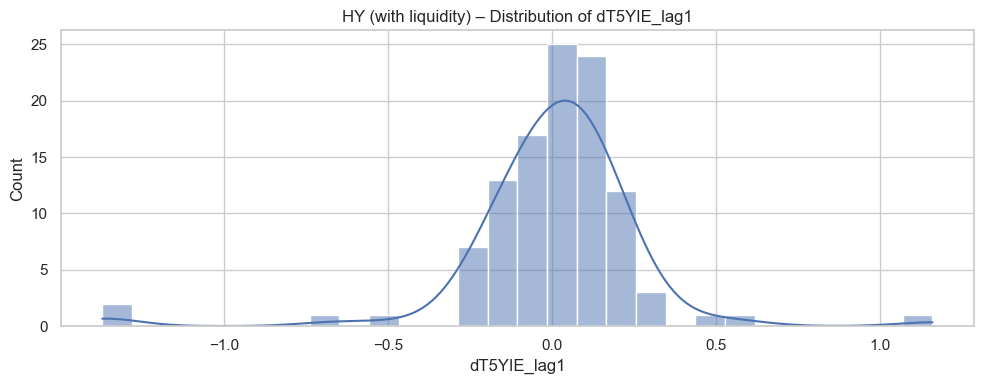

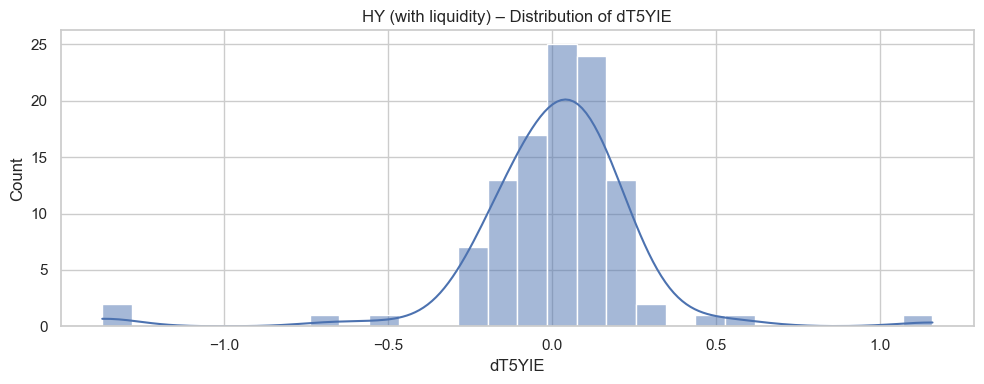

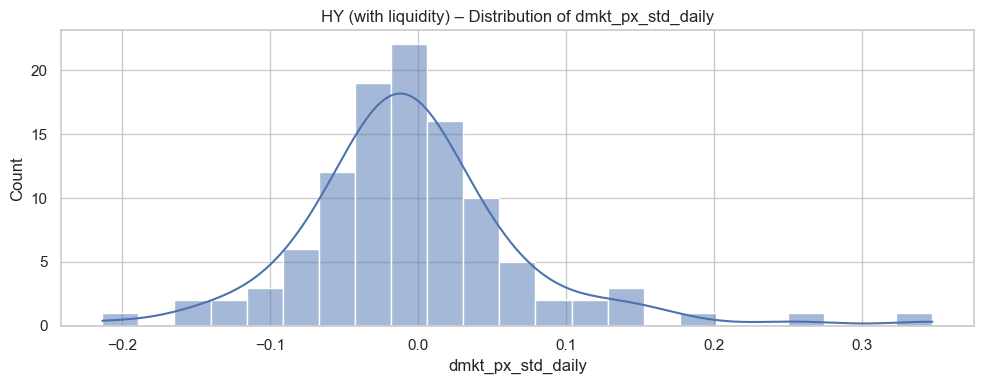


==== CORRELATIONS WITH TARGET ====
dHY_spread                1.000000
dmkt_px_std_daily         0.456586
dHY_spread_lag1           0.394967
VIXCLS_level              0.361561
dmkt_px_std_daily_lag1    0.285681
dT5YIFR_lag1              0.262210
ccsa_growth               0.245454
mkt_px_std_daily          0.214430
core_cpi_mom_lag1         0.118910
ccsa_growth_lag1          0.091832
indpro_mom                0.006356
core_cpi_mom             -0.007740
mkt_px_std_daily_lag1    -0.021423
ln_mkt_n_trades          -0.033722
cpi_mom_lag1             -0.043194
pce_mom_lag1             -0.060757
ln_mkt_n_trades_lag1     -0.081789
mkt_n_trades             -0.103005
ln_mkt_par_lb            -0.120425
indpro_mom_lag1          -0.148227
ln_mkt_par_lb_lag1       -0.153677
mkt_par_lb               -0.157867
UNRATE_lag1              -0.179360
dT10YIE_lag1             -0.283123
dT5YIFR                  -0.342772
cpi_mom                  -0.377986
pce_mom                  -0.403647
dT5YIE             

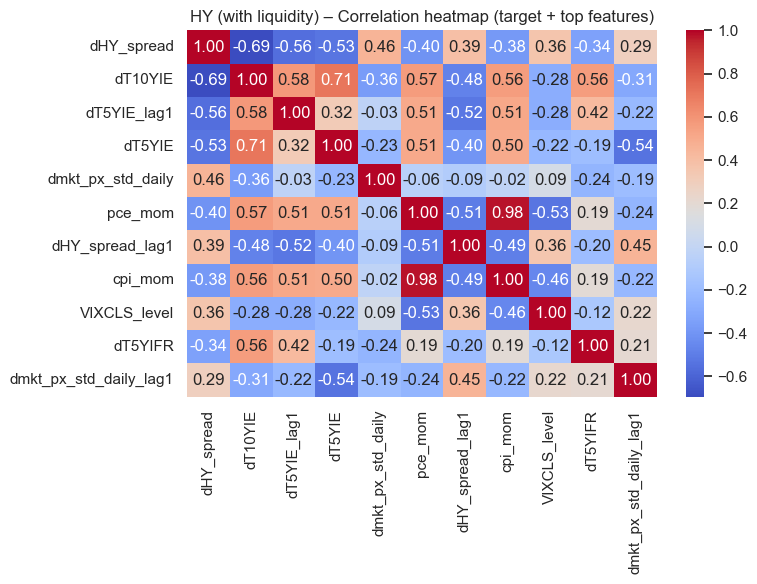


==== SCATTER PLOTS VS TARGET ====


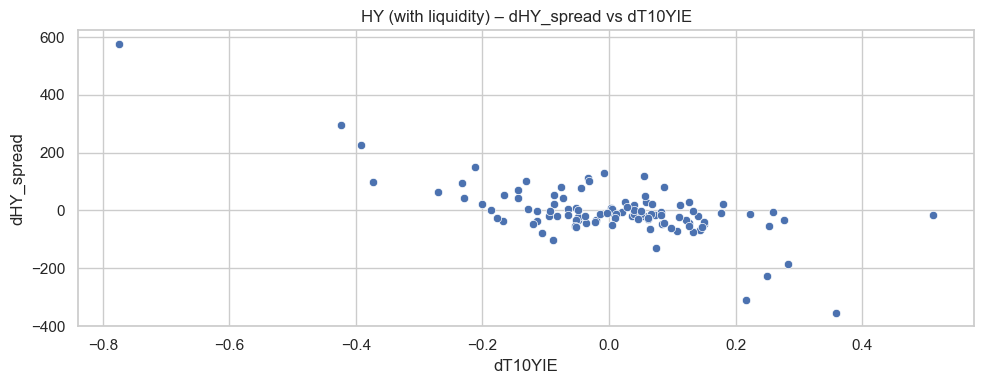

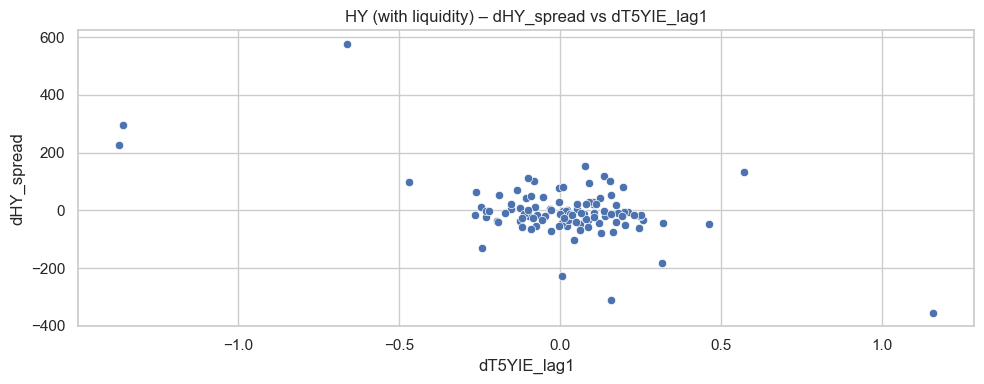

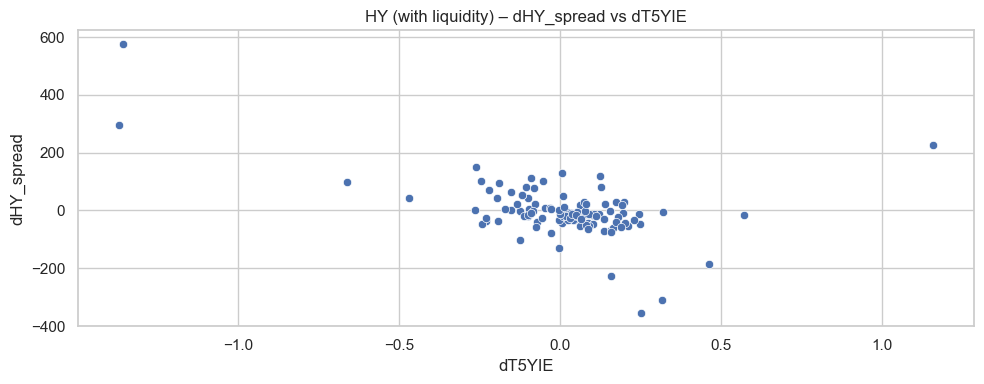

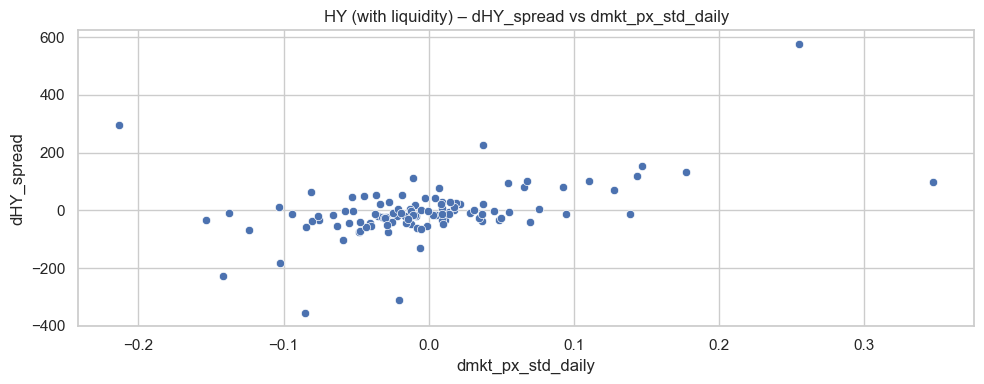

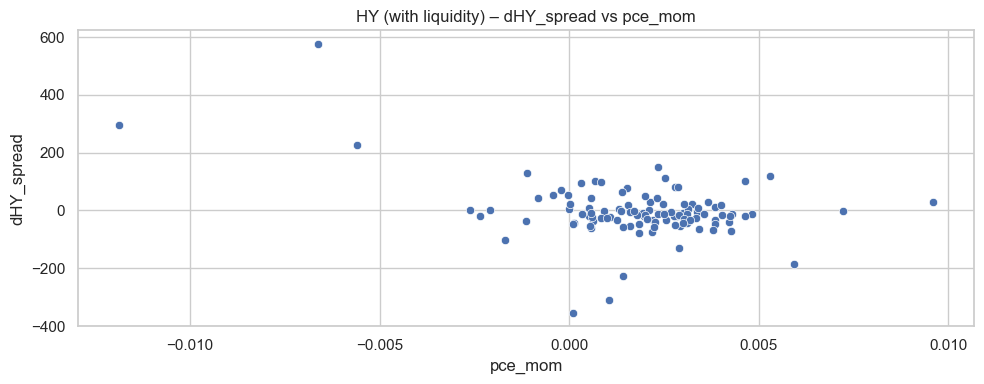

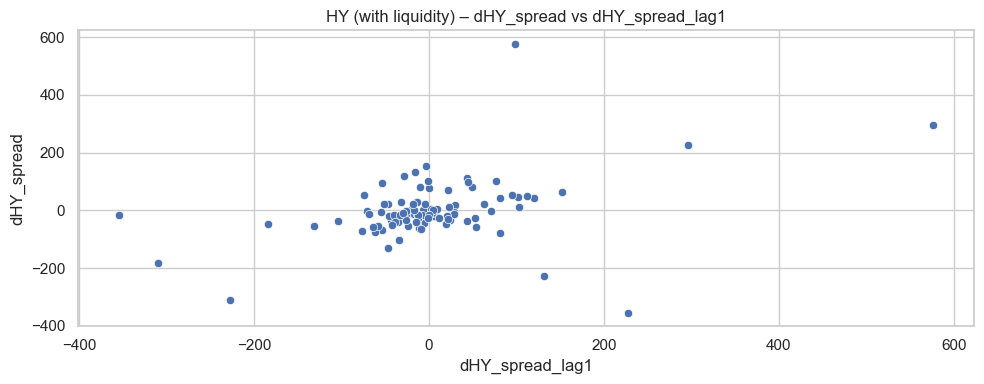

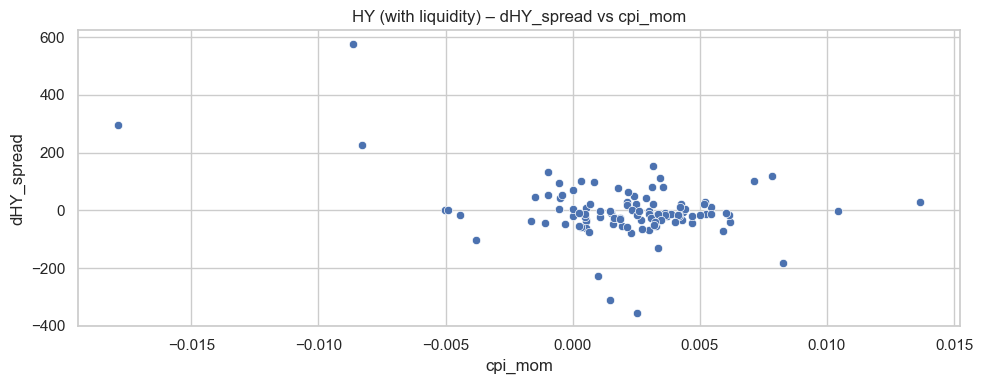

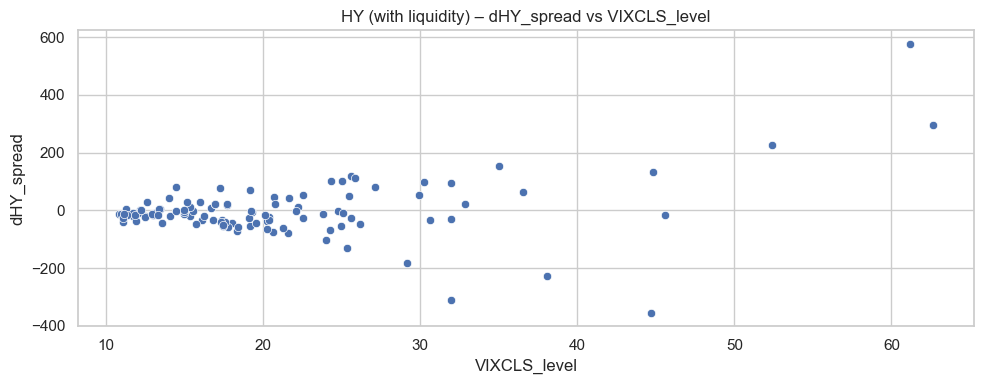

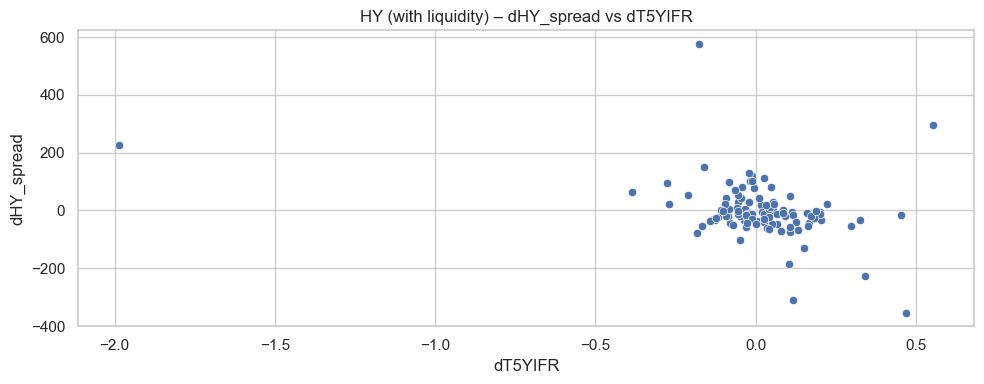

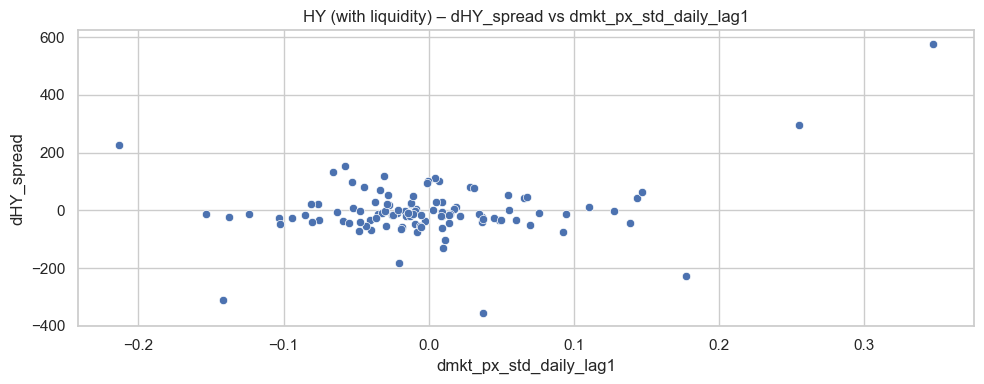


==== REGIME STABILITY (GFC, COVID) ====
             mean         std  count
regime                              
GFC     33.578824  192.945683     24
Other  -12.118055   41.712811     84


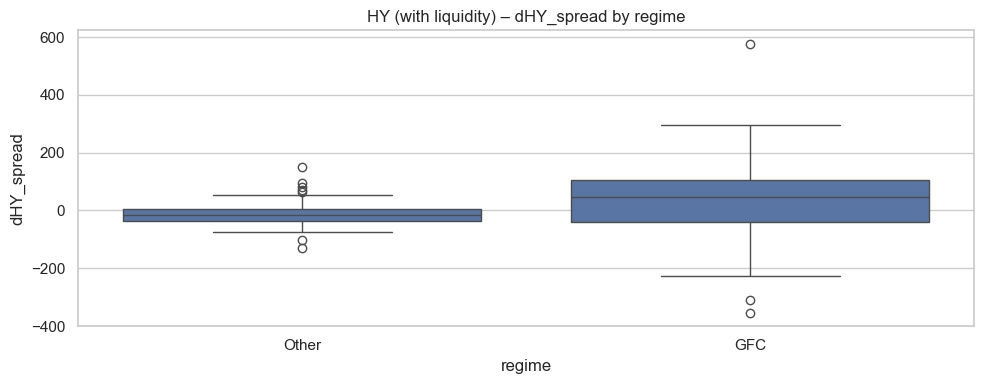

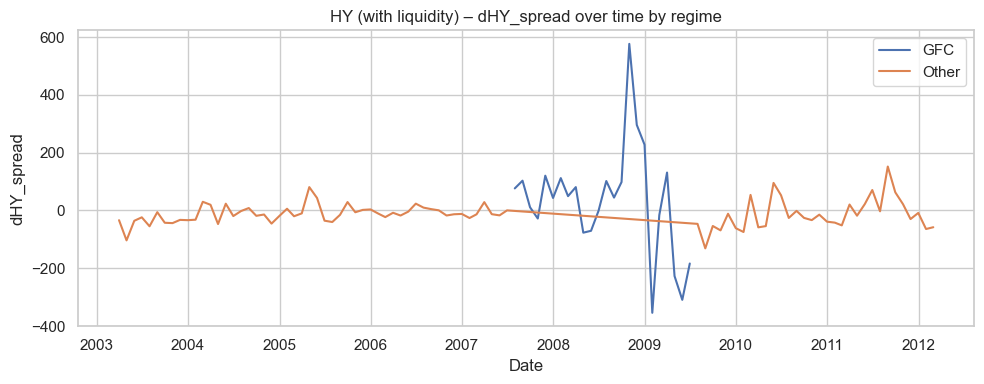


==== AUTOCORRELATION DIAGNOSTICS ====


<Figure size 1000x400 with 0 Axes>

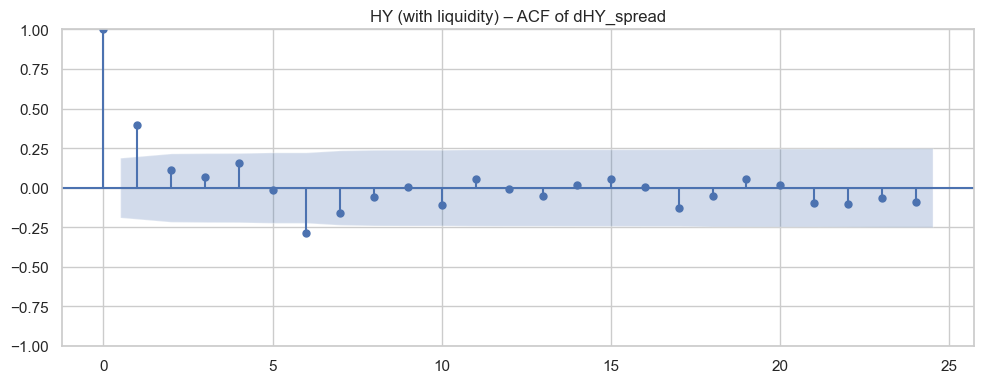

Ljung-Box test (H0: no autocorrelation):
      lb_stat  lb_pvalue
6   31.511753   0.000020
12  36.872163   0.000234
24  45.339485   0.005310


In [33]:
# HY with liquidity
df_hy_w = eda_one_dataset("data/master/master_HY_w_lqd.csv", target="dHY_spread",
                          label="HY (with liquidity)")



EDA for: IG (no liquidity)
File: data/master/master_IG_wo_lqd.csv

==== BASIC INFO ====
Shape: (271, 21)

Columns:
 ['Date', 'dIG_spread', 'dIG_spread_lag1', 'VIXCLS_level', 'cpi_mom', 'cpi_mom_lag1', 'core_cpi_mom', 'core_cpi_mom_lag1', 'pce_mom', 'pce_mom_lag1', 'indpro_mom', 'indpro_mom_lag1', 'ccsa_growth', 'ccsa_growth_lag1', 'UNRATE_lag1', 'dT5YIFR', 'dT5YIFR_lag1', 'dT5YIE', 'dT5YIE_lag1', 'dT10YIE', 'dT10YIE_lag1']

Target summary:
count    271.000000
mean      -0.125488
std       22.661694
min     -117.157143
25%       -8.319570
50%       -1.430642
75%        5.656789
max      157.907585
Name: dIG_spread, dtype: float64

Missing values (top 20):
Date                 0
indpro_mom_lag1      0
dT10YIE              0
dT5YIE_lag1          0
dT5YIE               0
dT5YIFR_lag1         0
dT5YIFR              0
UNRATE_lag1          0
ccsa_growth_lag1     0
ccsa_growth          0
indpro_mom           0
dIG_spread           0
pce_mom_lag1         0
pce_mom              0
core_cpi_mom_

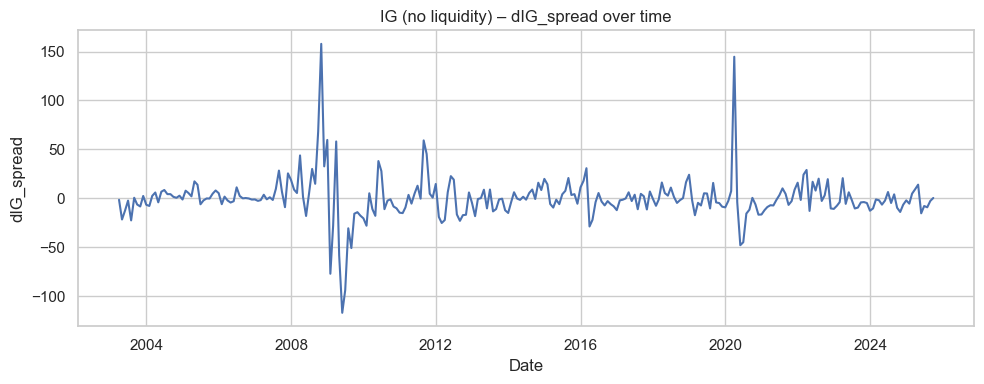


==== DISTRIBUTIONS ====


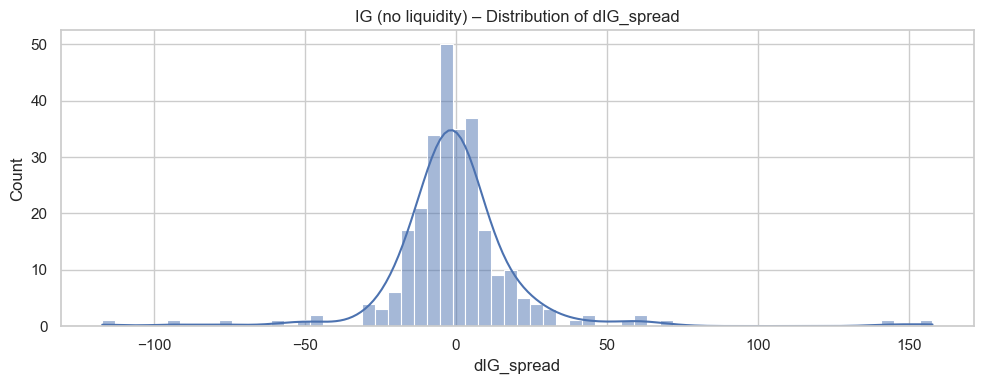

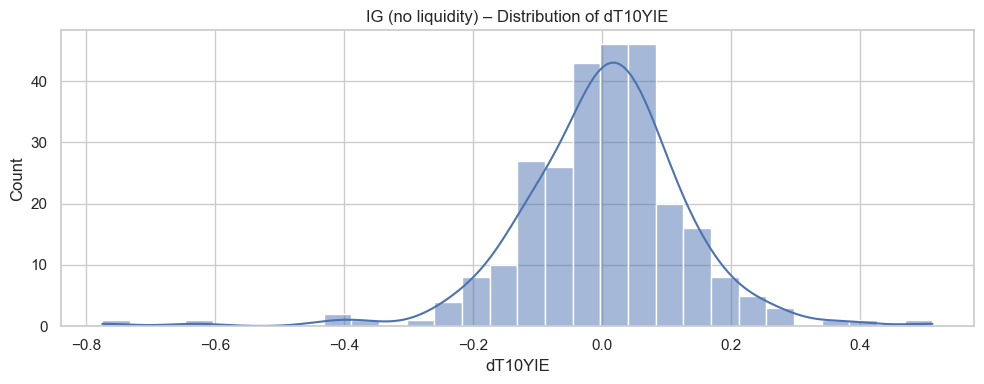

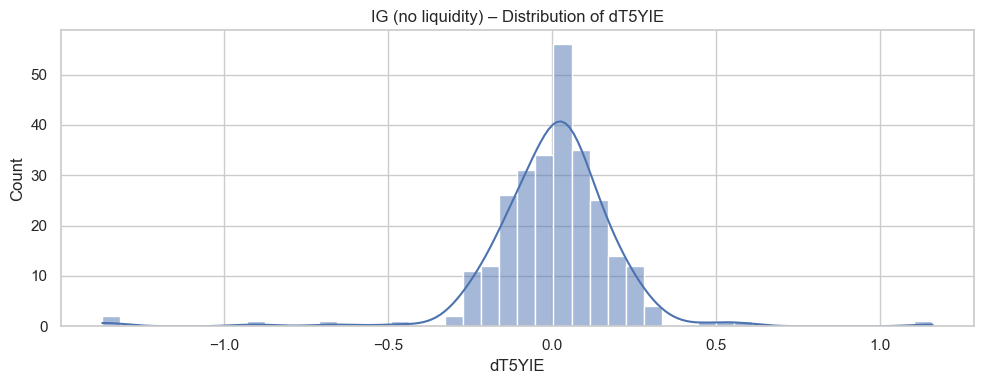

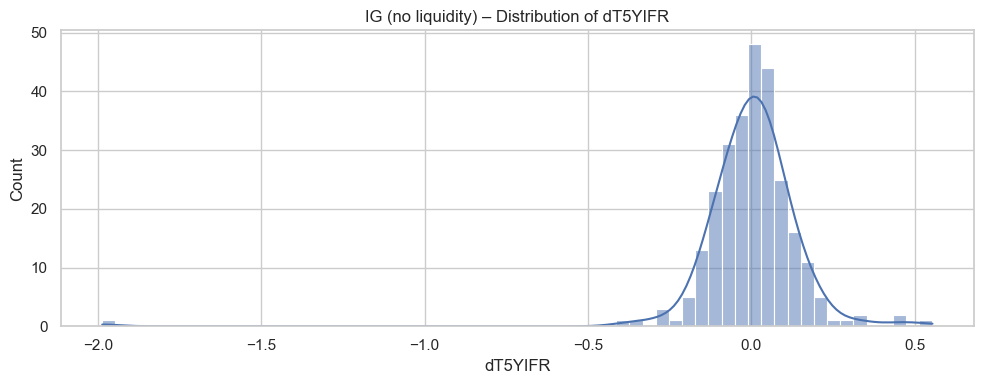

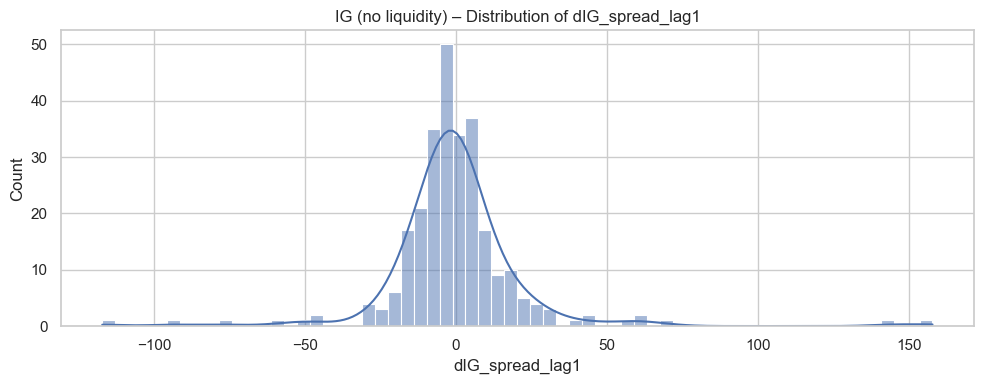


==== CORRELATIONS WITH TARGET ====
dIG_spread           1.000000
dIG_spread_lag1      0.370158
VIXCLS_level         0.319916
ccsa_growth          0.182685
core_cpi_mom_lag1    0.167265
dT5YIFR_lag1         0.070292
indpro_mom_lag1      0.035982
cpi_mom_lag1         0.022481
pce_mom_lag1         0.015478
core_cpi_mom        -0.014228
ccsa_growth_lag1    -0.097393
indpro_mom          -0.127474
dT10YIE_lag1        -0.232568
UNRATE_lag1         -0.236190
cpi_mom             -0.273171
pce_mom             -0.274355
dT5YIE_lag1         -0.351849
dT5YIFR             -0.428007
dT5YIE              -0.538363
dT10YIE             -0.685686
Name: dIG_spread, dtype: float64


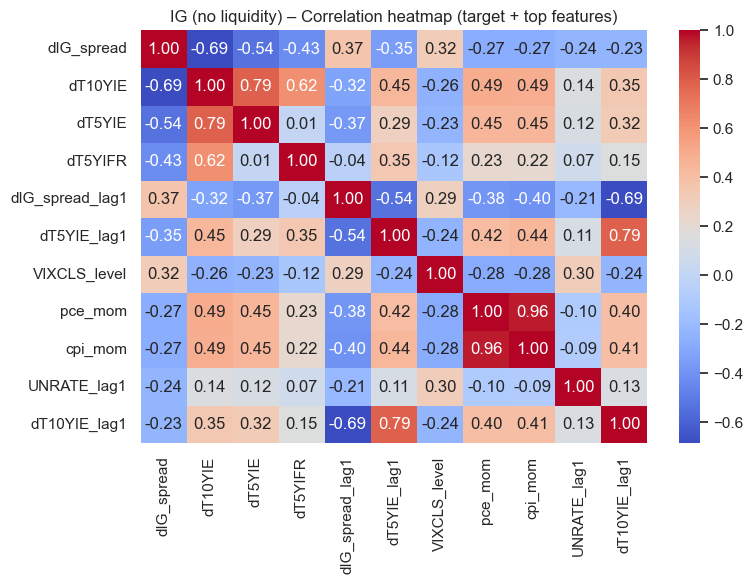


==== SCATTER PLOTS VS TARGET ====


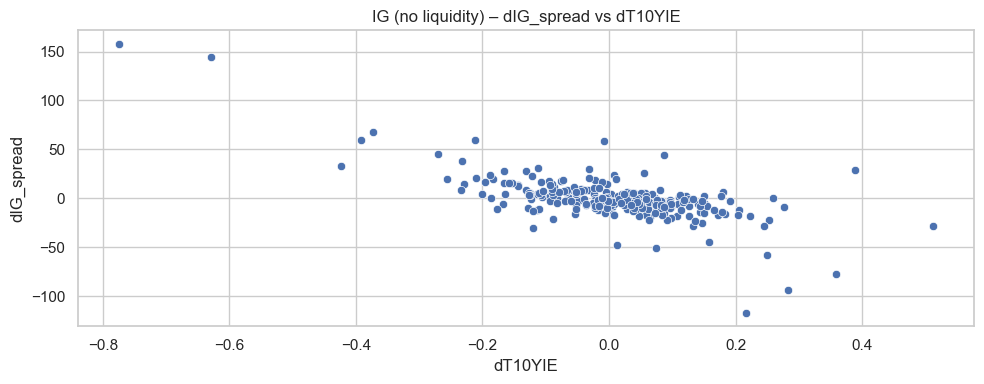

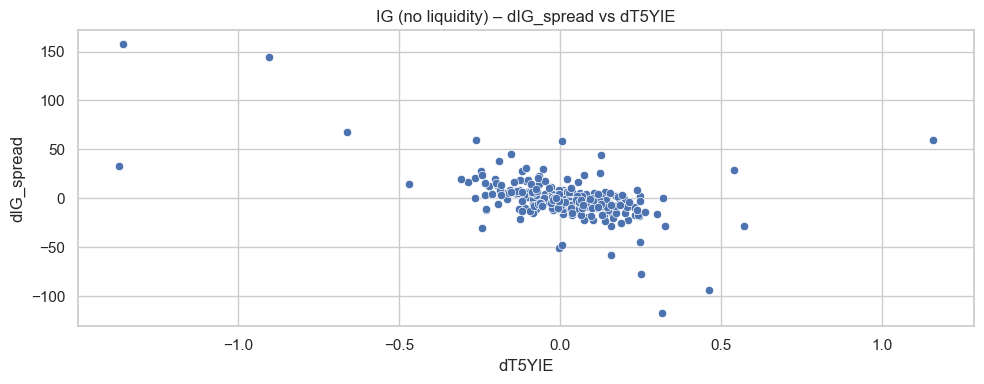

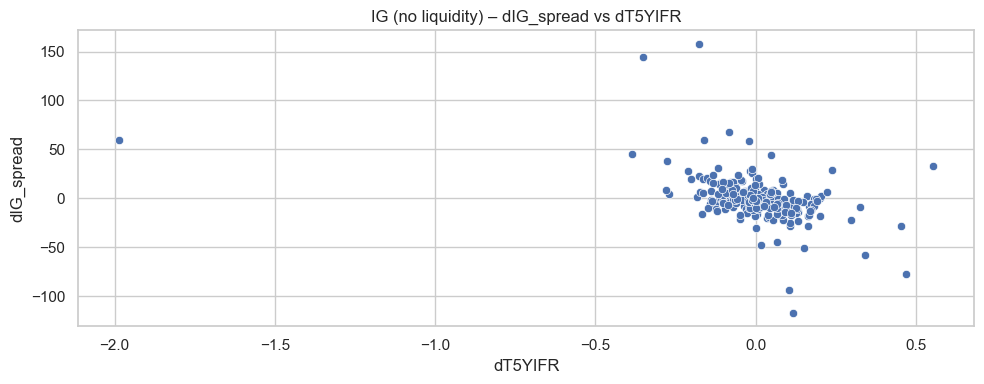

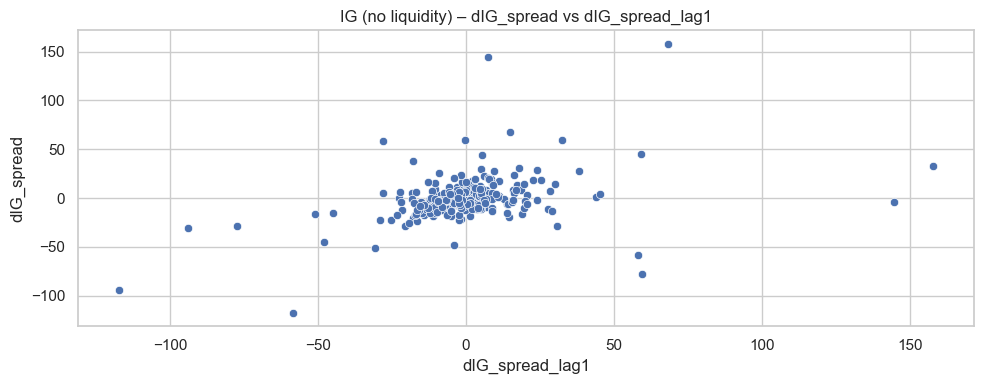

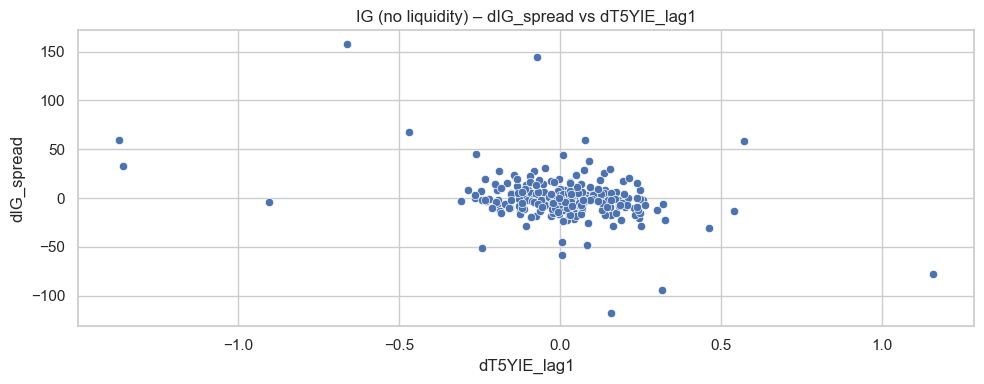

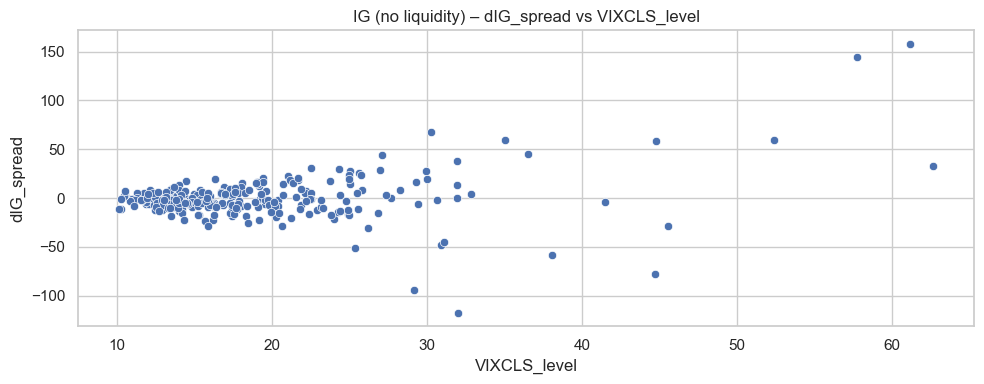

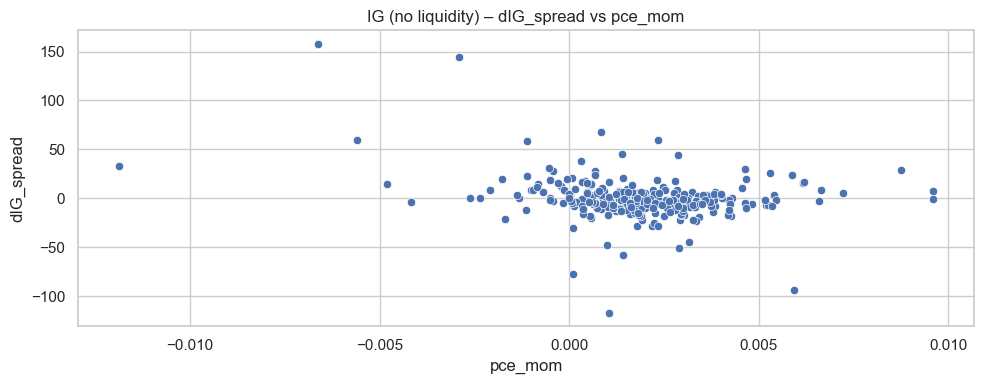

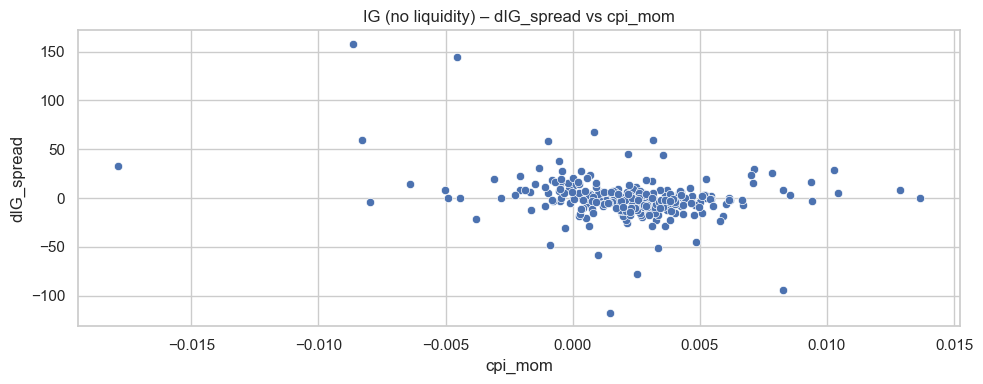

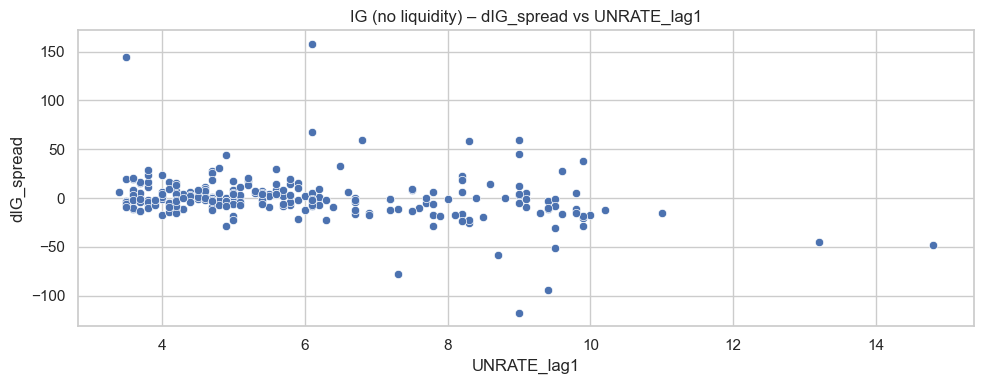

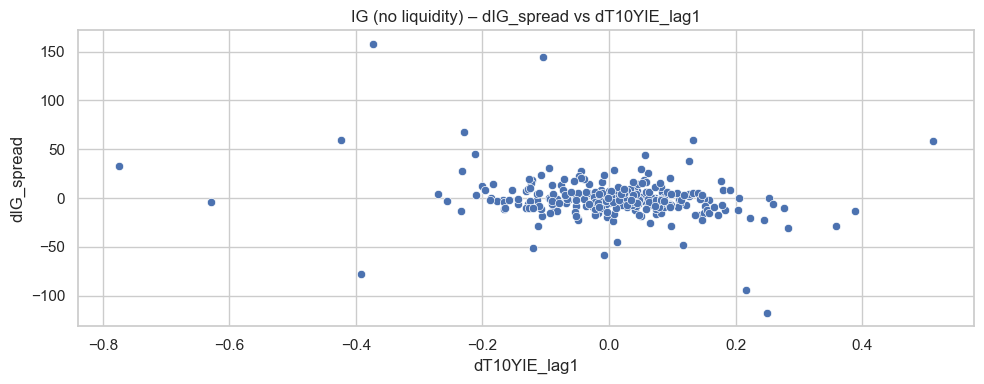


==== REGIME STABILITY (GFC, COVID) ====
            mean        std  count
regime                            
COVID  -0.694146  35.139882     23
GFC     7.182359  56.944648     24
Other  -0.850082  12.617981    224


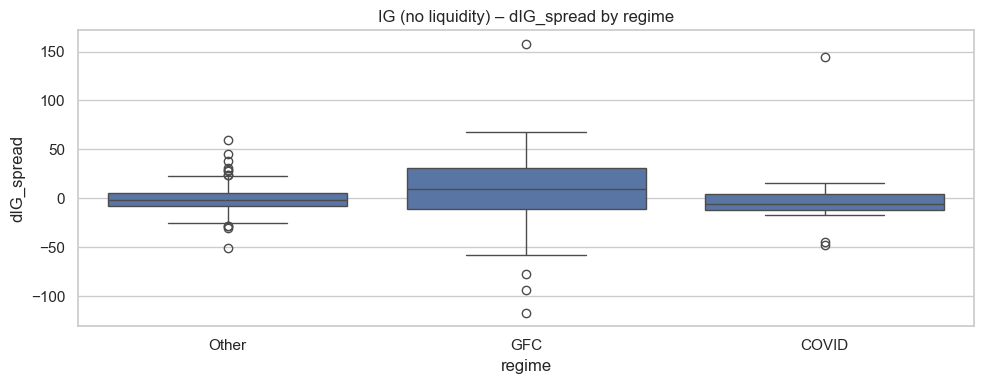

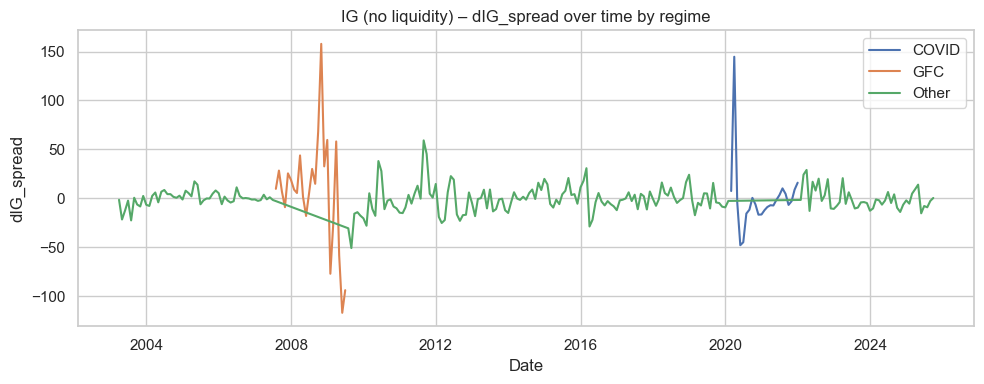


==== AUTOCORRELATION DIAGNOSTICS ====


<Figure size 1000x400 with 0 Axes>

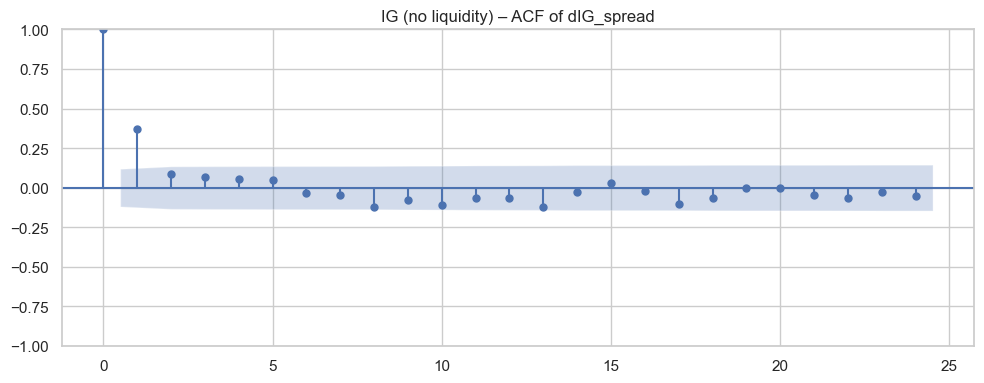

Ljung-Box test (H0: no autocorrelation):
      lb_stat     lb_pvalue
6   42.819780  1.266241e-07
12  55.476675  1.486407e-07
24  67.924304  4.489231e-06


In [34]:
# IG without liquidity
df_ig_wo = eda_one_dataset("data/master/master_IG_wo_lqd.csv", target="dIG_spread",
                           label="IG (no liquidity)")



EDA for: HY (no liquidity)
File: data/master/master_HY_wo_lqd.csv

==== BASIC INFO ====
Shape: (271, 21)

Columns:
 ['Date', 'dHY_spread', 'dHY_spread_lag1', 'VIXCLS_level', 'cpi_mom', 'cpi_mom_lag1', 'core_cpi_mom', 'core_cpi_mom_lag1', 'pce_mom', 'pce_mom_lag1', 'indpro_mom', 'indpro_mom_lag1', 'ccsa_growth', 'ccsa_growth_lag1', 'UNRATE_lag1', 'dT5YIFR', 'dT5YIFR_lag1', 'dT5YIE', 'dT5YIE_lag1', 'dT10YIE', 'dT10YIE_lag1']

Target summary:
count    271.000000
mean      -2.133490
std       71.727439
min     -354.059091
25%      -27.926004
50%       -9.987150
75%       16.911425
max      576.424620
Name: dHY_spread, dtype: float64

Missing values (top 20):
Date                 0
indpro_mom_lag1      0
dT10YIE              0
dT5YIE_lag1          0
dT5YIE               0
dT5YIFR_lag1         0
dT5YIFR              0
UNRATE_lag1          0
ccsa_growth_lag1     0
ccsa_growth          0
indpro_mom           0
dHY_spread           0
pce_mom_lag1         0
pce_mom              0
core_cpi_mom_

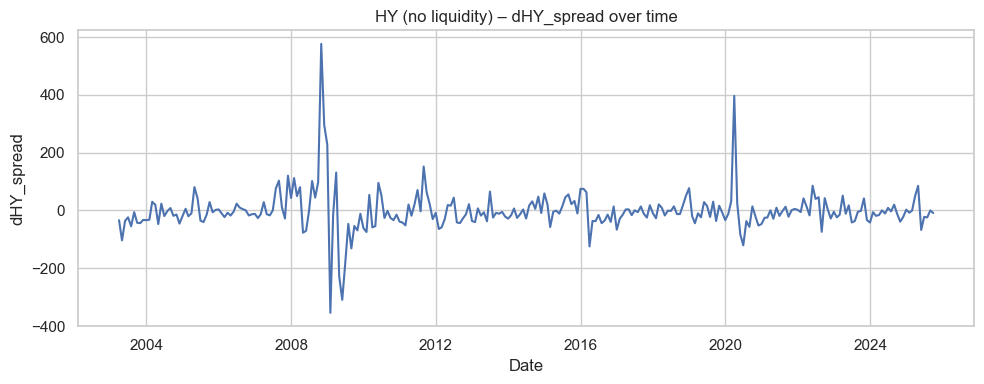


==== DISTRIBUTIONS ====


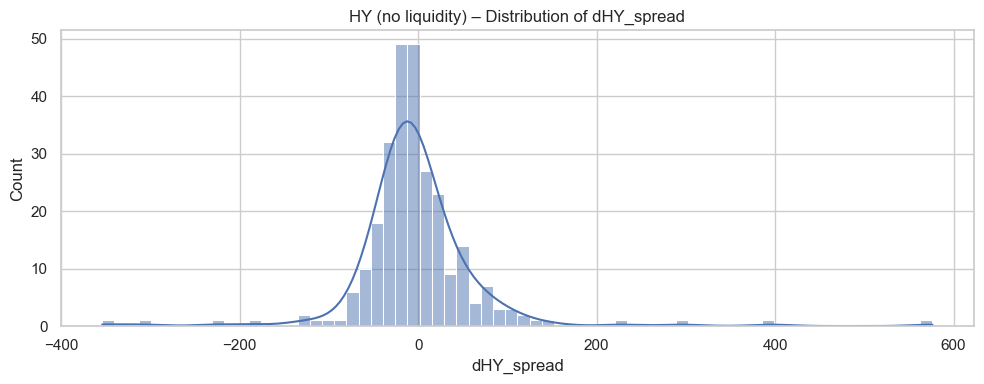

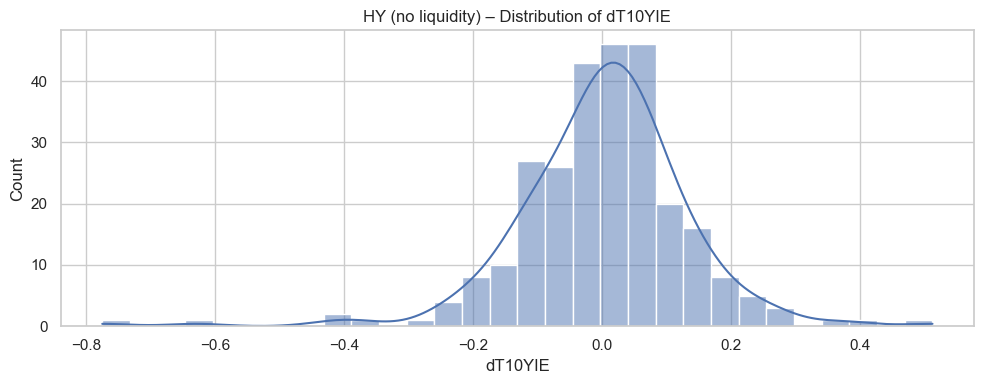

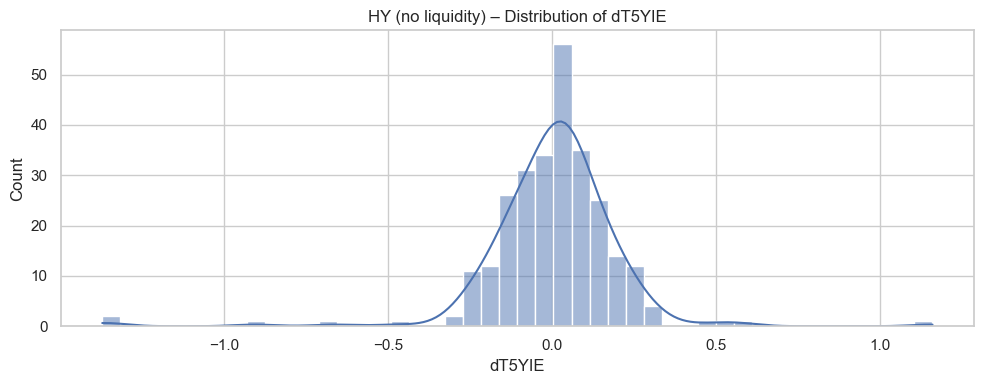

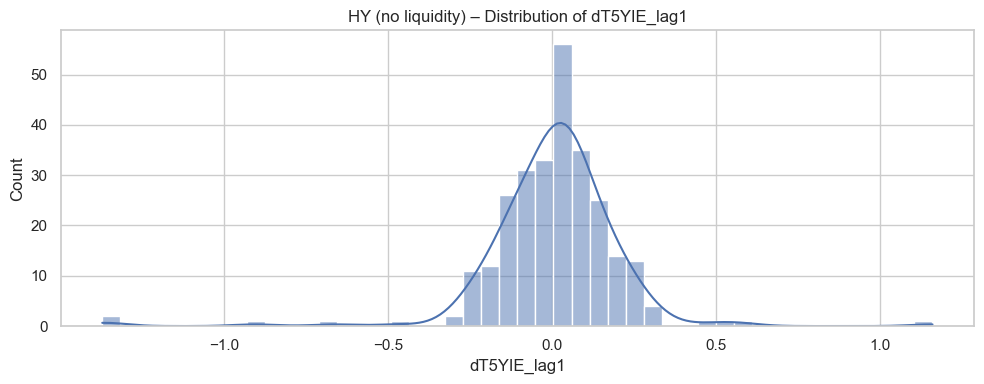

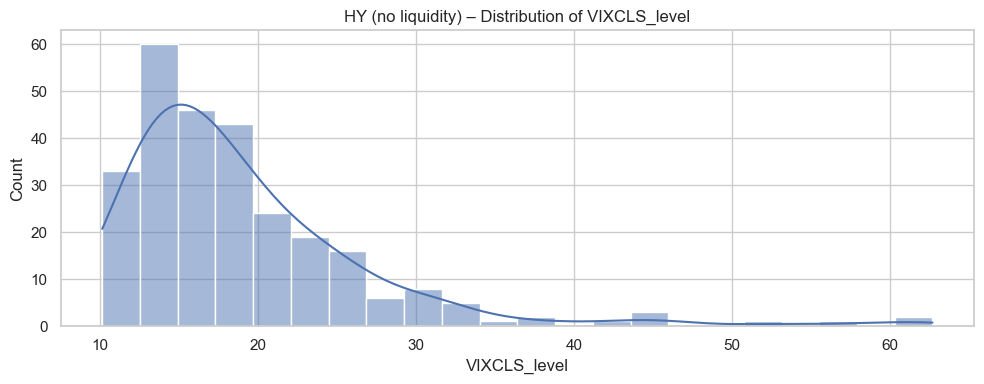


==== CORRELATIONS WITH TARGET ====
dHY_spread           1.000000
VIXCLS_level         0.387040
dHY_spread_lag1      0.336880
ccsa_growth          0.206676
dT5YIFR_lag1         0.172696
core_cpi_mom_lag1    0.095513
cpi_mom_lag1        -0.012406
pce_mom_lag1        -0.017523
ccsa_growth_lag1    -0.028051
indpro_mom_lag1     -0.033810
core_cpi_mom        -0.045581
indpro_mom          -0.120459
UNRATE_lag1         -0.187498
dT10YIE_lag1        -0.232201
cpi_mom             -0.322341
pce_mom             -0.331022
dT5YIFR             -0.382403
dT5YIE_lag1         -0.431570
dT5YIE              -0.570915
dT10YIE             -0.683358
Name: dHY_spread, dtype: float64


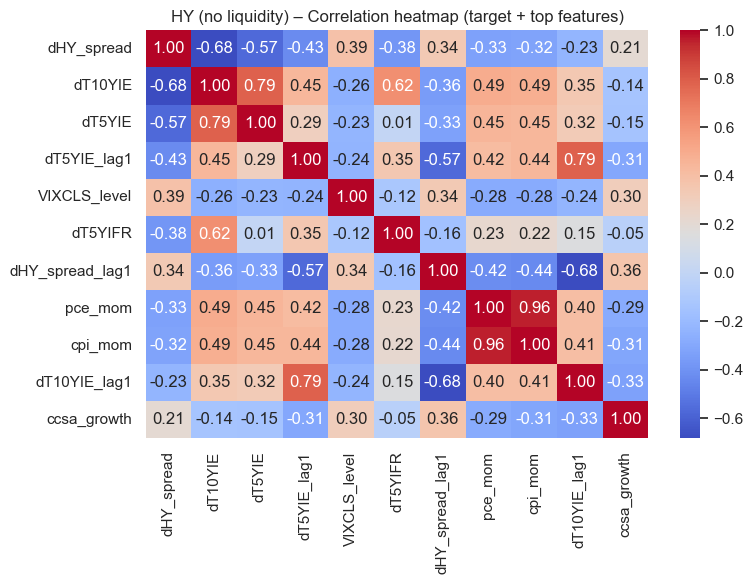


==== SCATTER PLOTS VS TARGET ====


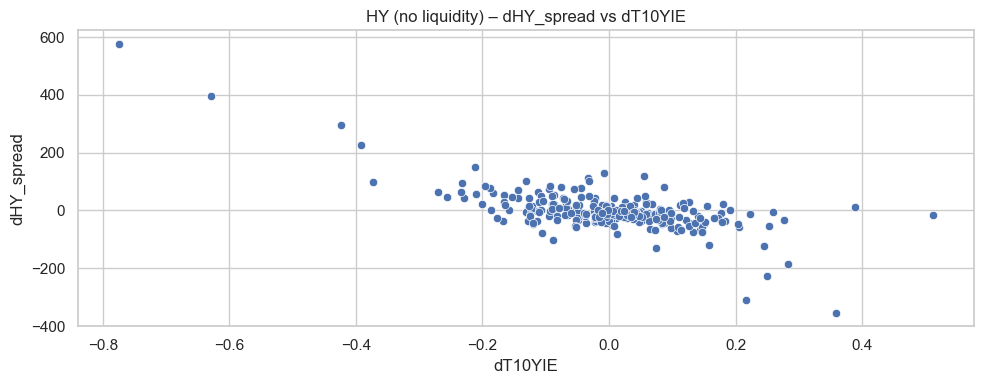

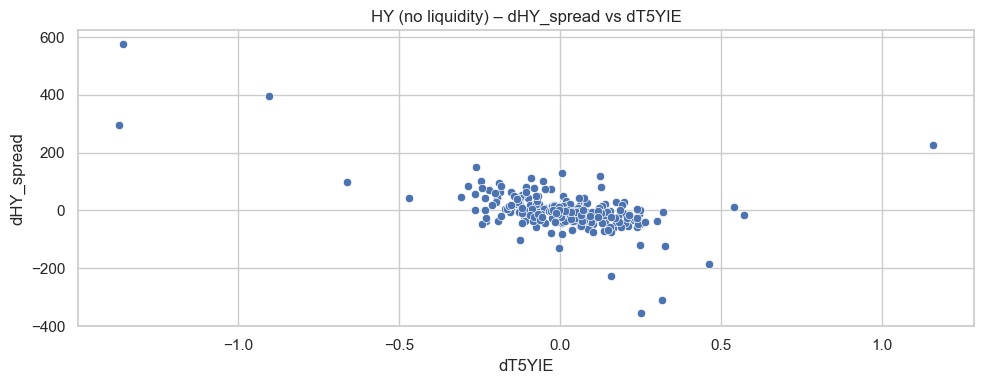

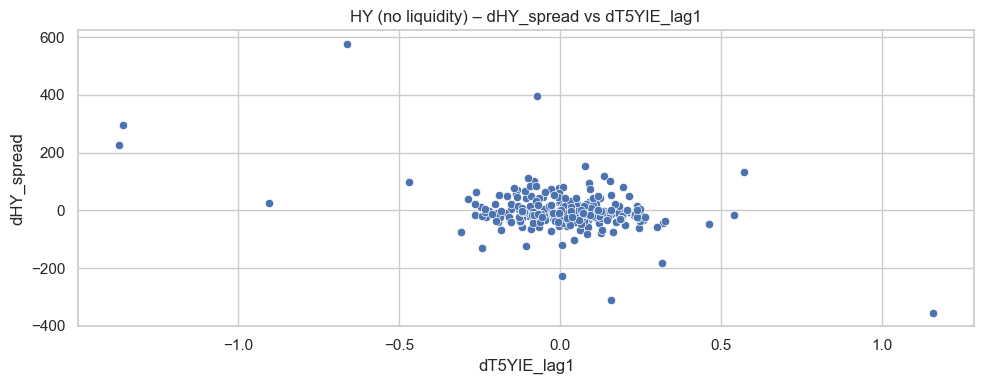

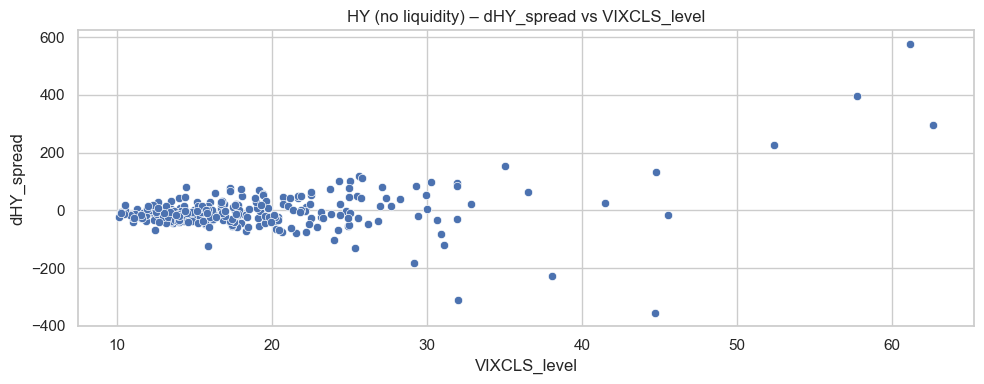

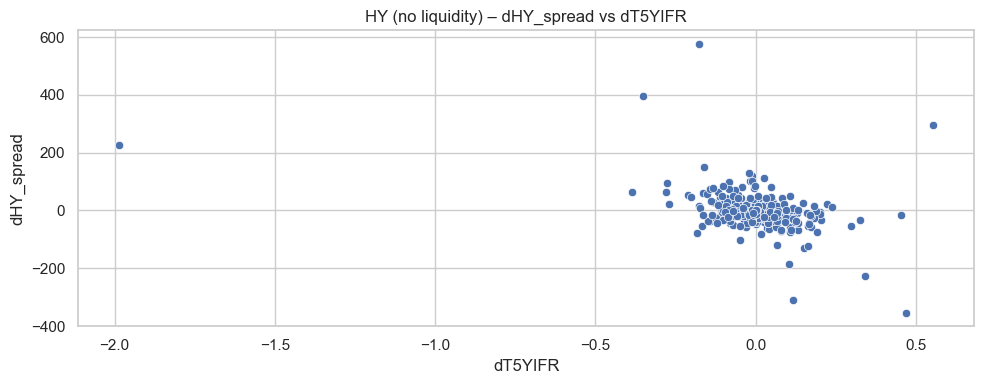

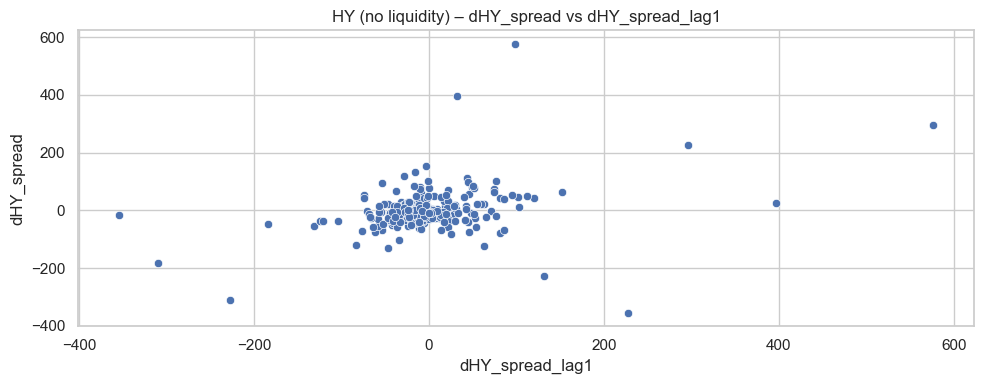

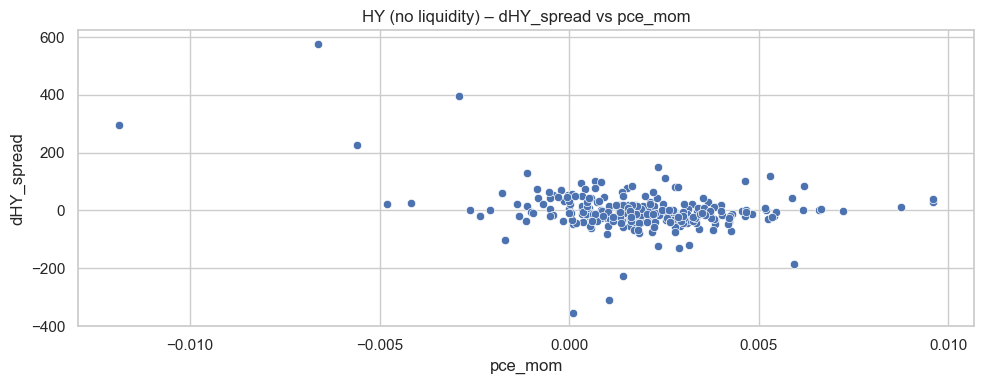

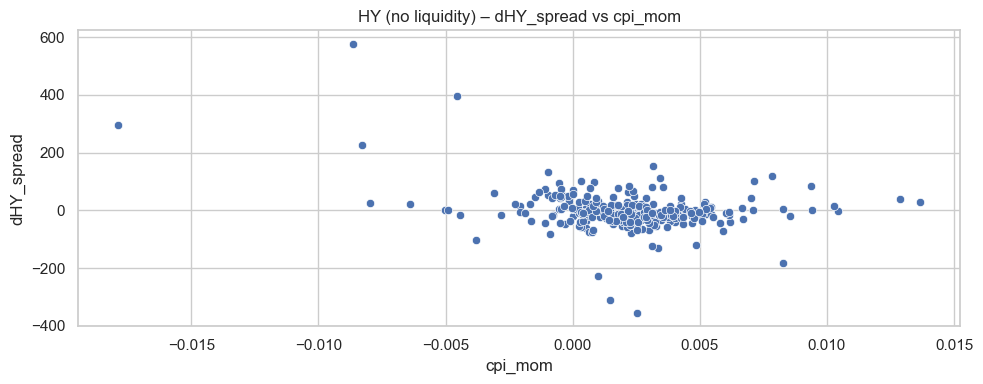

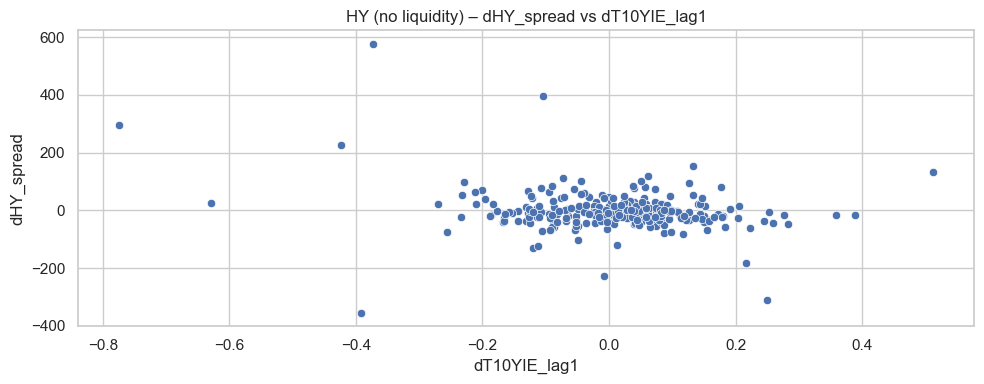

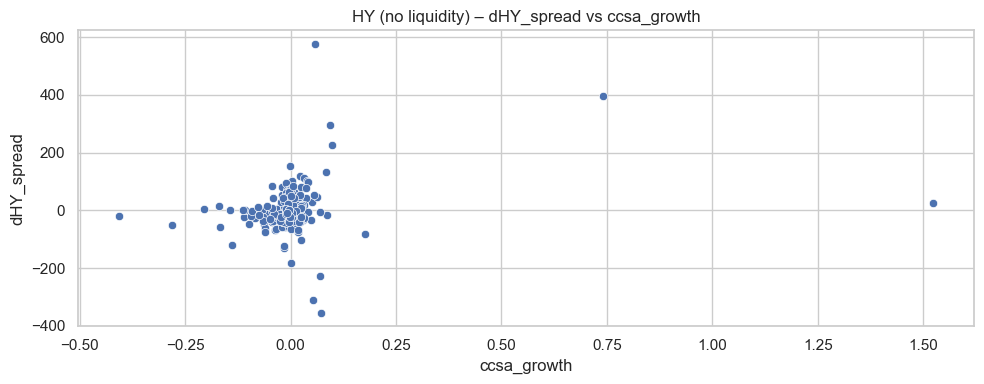


==== REGIME STABILITY (GFC, COVID) ====
             mean         std  count
regime                              
COVID   -1.720873   93.783845     23
GFC     33.578824  192.945683     24
Other   -6.002177   37.006465    224


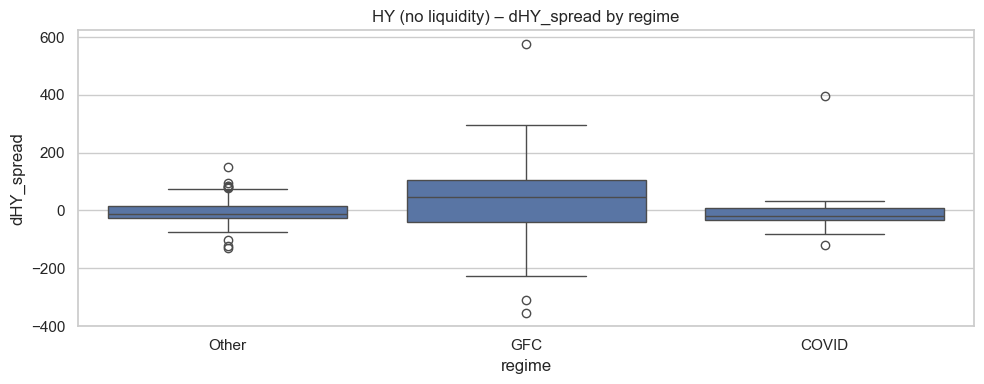

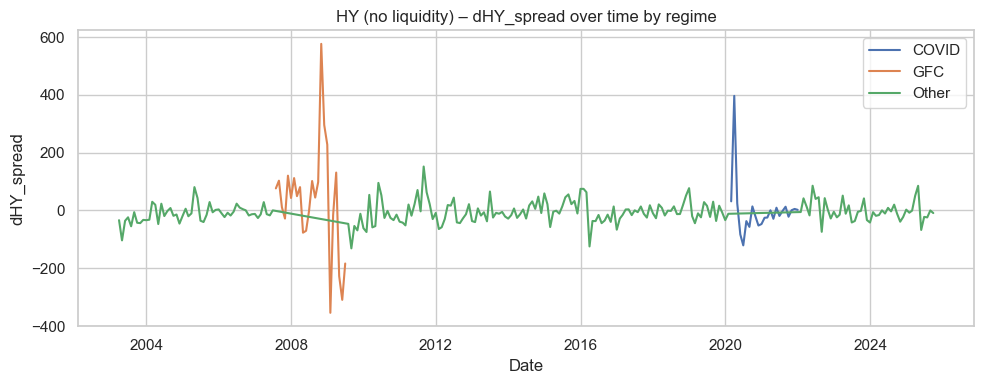


==== AUTOCORRELATION DIAGNOSTICS ====


<Figure size 1000x400 with 0 Axes>

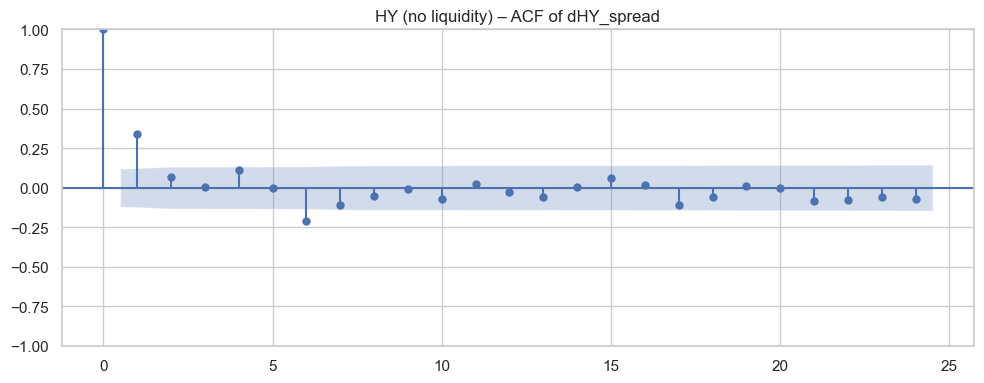

Ljung-Box test (H0: no autocorrelation):
      lb_stat     lb_pvalue
6   48.134666  1.110624e-08
12  54.252342  2.463191e-07
24  67.668837  4.901706e-06


In [35]:
# HY without liquidity
df_hy_wo = eda_one_dataset("data/master/master_HY_wo_lqd.csv", target="dHY_spread",
                           label="HY (no liquidity)")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure Date is datetime and set as index
reg_ready["Date"] = pd.to_datetime(reg_ready["Date"])
reg_ready = reg_ready.sort_values("Date").set_index("Date")

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(reg_ready.index, reg_ready["BAMLC0A0CMEY"], label="IG spread (BAMLC0A0CMEY)")
ax.plot(reg_ready.index, reg_ready["BAMLH0A0HYM2EY"], label="HY spread (BAMLH0A0HYM2EY)")
ax.plot(reg_ready.index, reg_ready["DGS10"], label="10Y Treasury (DGS10)")
ax.plot(reg_ready.index, reg_ready["DGS5"], label="5Y Treasury (DGS5)")

ax.set_title("Corporate Bond Yields and Treasury Yields Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Yield (%)")

# Nice date formatting
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))    # every 2 years
ax.xaxis.set_minor_locator(mdates.YearLocator())          # every year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

fig.autofmt_xdate()  # rotate & align dates
ax.grid(True, which="both", linestyle="--", alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()
